# GE health Assesment 

## Introduction

For the position of staff data scientist I have been giving this assignement for my technical skills to be tested. This assigment contains 13 questions that need to be answered. The questions are: 

1. How are systemid, location, and serial_number related to each other, i.e. what is their relative cardinality: many to one to many, many to many to many, etc.?
2. Are any of the serial_numbers associated with multiple systemids?
3. Within individual systemids, are the locations for individual serial_numbers strictly sequential in time, i.e. for serial_numbers with multiple locations within a systemid, are there any cases where a location shows up in more than one continuous time interval?
4. Do any of the v1 time series for individual serial_numbers have outliers? If so, can you explain the outliers with any of the other data?
5. Are there any serial_numbers that have a linear trend in v1 over time?
6. Propose and implement a method to classify the qualitative shape of the v1 time series for serial_numbers. The classification is left up to you and obviously the higher the granularity in classification the better.
7. Assess the performance of the classifier in 6). How would you maximize the performance?
8. For serial_number 11410W0294, can you characterize the noise in v1?
9. How many serial_numbers have a v1 with a qualitative shape like serial_number 11410W0294?
10. If there are no other serial_numbers with a qualitative shape like serial_number 11410W0294, can you create a machine learning model to predict time to reach the horizontal clipping that occurs at the end of the time series? If there are other serial_numbers with a qualitative shape like 11410W0294, can you create a machine learning model to predict the time to reach the horizontal clipping?
11. Assess the performance of the model/s in 10).
12. Can you select some serial_numbers and create time series models to forecast v2?
13. Assess the performance of the models in 12).

The assignement will be divided as follows: Section 1, where I import the needed packages. Section 2, where some useful function will be added to simply later stages of the code, section 3 importing of the data and quick snapshot of it's nature and compeleteness.   

## 1. Importing packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress,shapiro,pearsonr
from scipy.interpolate import interp1d
import statsmodels.api as sm
from scipy.signal import savgol_filter as SF
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from sklearn.cluster import KMeans
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam


2024-05-01 14:18:22.094977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import statsmodels
import keras
import sklearn
import tensorflow as tf
import tqdm as tq
import scipy
import matplotlib
import tensorflow

# to make sure this code works on your system, I will not send you any yml or containers, instead just post the versions here
for package in [np,pd,matplotlib,scipy,statsmodels,keras,tensorflow,tq,sklearn]:
    print(f"Version of {package.__name__} --> {package.__version__}")

Version of numpy --> 1.23.5
Version of pandas --> 2.1.1
Version of matplotlib --> 3.8.4
Version of scipy --> 1.13.0
Version of statsmodels --> 0.14.0
Version of keras --> 2.12.0
Version of tensorflow --> 2.12.0
Version of tqdm --> 4.66.2
Version of sklearn --> 1.3.0


## 2. import useful functions

Usually in bigger scripts utility and help functions sit externally within the project I added it here in this section for ease of presentation purposes

In [3]:
def print_info(message):
    """A function to print clear results neatly"""
    print(f"\n[INFO]: {message} \n")



def analyze_cardinality(df, col1, col2):
    """This function analyzes cardinality which in methematical terms means the number of elements in a set""" 

    cardinality = 'Uknown'
    
    # Get unique counts of key columns in each table
    unique_counts_1= df[col1].nunique()
    unique_counts_2= df[col2].nunique()

    # Calculate cardinality ratios
    ratio = unique_counts_1 / unique_counts_2

    # Determine relationship based on ratio
    if ratio == 1:
        cardinality = "one-to-one"
    elif ratio > 1:
        cardinality = "one-to-many"
    else:
        cardinality= "many-to-one"  # This case is not typical in database relationships

    return cardinality

def cardinality_math(col1,col2):
    """This function analyzes cardinality which in methematical terms means the number of elements in a set""" 
    
    count1 = len(set(col1))
    count2 = len(set(col2))
    cardinality = "Unknown"

    if count1 == 1 and count2 == 1 : 
        cardinality = "One-to-One"
    if count1 == 1 and count2 > 1: 
        cardinality = "One-to-Many"
    if count1 > 1 and count2 == 1: 
        cardinality = "Many-to-One" 
    if count1 > 1 and count2 > 1: 
        cardinality = "Many-to-Many" 
        
    return cardinality


def intersection_range(segments):
    # Initialize with the first segment as the starting range
    if not segments:
        return None
    
    current_range = segments[0]
    
    # Iterate through each segment to find the intersection range
    for segment in segments[1:]:
        # Calculate the intersection of current_range with the next segment
        current_start, current_end = current_range
        next_start, next_end = segment
        
        # Update the current_range to be the overlapping part
        new_start = max(current_start, next_start)
        new_end = min(current_end, next_end)
        
        # If there's no overlap, return None (no intersection)
        if new_start > new_end:
            return None
        
        current_range = (new_start, new_end)
    
    return current_range


def classify_time_series(ts,visualize=False):
    """
    Classify the type of time series based on its shape and patterns.

    Args:
    ts (pd.Series): Time series data as a pandas Series.

    Returns:
    str: Type of time series based on its characteristics.
    """
    output = {} 

    # Constants 
    if ts.nunique() == 1: 
        # outputs 
        output['p_value_SW'] = 0.05  
        output['seasonal_component'] = np.nan
        output['trend_component'] = np.nan
        output['residual_component'] = np.nan
        output['result'] = "Constant"
        
        

        return output
        
    else:
        # Check for trend using Augmented Dickey-Fuller test
        result = sm.tsa.adfuller(ts)
        p_value_adf = result[1]
        has_trend = p_value_adf > 0.05  # True if there is no significant trend 
        
        # Check for seasonality
        seasonal = False
        decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
        seasonal_component = decomposition.seasonal
        trend_component = decomposition.trend
        residual_component = decomposition.resid

    
        # Shapiro Wilke test to see if the residual is normally distributed
        stat, p_value_sw = shapiro(residual_component.dropna())
        
        # outputs 
        output['p_value_SW'] = p_value_sw  
        output['seasonal_component'] = seasonal_component
        output['trend_component'] = trend_component
        output['residual_component'] = residual_component
        
        if len(seasonal_component) > 0:
            seasonal = True
        if has_trend and not seasonal:
            output['result'] = "Stationary Time Series"
        elif has_trend and seasonal:
            output['result'] =  "Seasonal Time Series"
        elif not has_trend and not seasonal:
            output['result'] =  "Cyclic Time Series"
        else:
            output['result'] =  "Trending Time Series"


        if visualize:
            # Plot the decomposed components
            plt.figure(figsize=(12, 8))
            plt.subplot(411)
            plt.plot(ts, label='Original')
            plt.legend(loc='upper left')
            plt.subplot(412)
            plt.plot(trend_component, label='Trend')
            plt.legend(loc='upper left')
            plt.subplot(413)
            plt.plot(seasonal_component, label='Seasonality')
            plt.legend(loc='upper left')
            plt.subplot(414)
            plt.plot(residual_component, label='Residuals')
            plt.legend(loc='upper left')
            plt.suptitle(output['result'])
            plt.tight_layout()
            plt.show()



        
        return output


def interpolate(y):

    cond = [~np.isnan(i) for i in y]
    x_obs = np.arange(len(y))[cond]
    y_obs = y[cond]
                      
    # Create linear interpolation function
    interp_func = interp1d(x_obs, y_obs, kind='linear', fill_value='interpolate')

    return interp_func(np.arange(len(y)))

def diff_window(arr, window_size, pad_value=np.nan):
    """
    Compute the moving difference over a specified window size for the input array,
    and pad the output array to match the size of the input array.

    Parameters:
    arr (numpy.ndarray): Input array.
    window_size (int): Size of the moving window.
    pad_value: Value to use for padding (default is np.nan).

    Returns:
    numpy.ndarray: Array of moving differences padded to match the size of the input array.
    """
    # Compute the moving differences
    moving_diff = np.zeros_like(arr)
    for i in range(window_size, len(arr)):
        moving_diff[i] = arr[i] - arr[i - window_size]

    # Pad the output array to match the size of the input array
    pad_length = len(arr) - len(moving_diff)
    if pad_length > 0:
        padding = np.full(pad_length, pad_value)
        moving_diff = np.concatenate((padding, moving_diff))

    return moving_diff

    
    
def plateau_clustering(arr_time,arr_values,window_size=3,n_clus=10):

    arr_orig = np.array(arr_values.copy())
    
    # fix format and standardize
    arr_values = np.array(arr_values)
    arr_time = np.array(arr_time)
    arr_values  = (arr_values - np.nanmean(arr_values))/np.nanstd(arr_values)
    
    # Compute differences between consecutive values manually
    diff_values = diff_window(arr_values,window_size=window_size)

    # Normalize
    diff_values_norm = (diff_values - diff_values.mean())/diff_values.std()
    values_norm = 1 + ((arr_values - arr_values.min())/(arr_values.max() - arr_values.min()))

    
    # Extract features (values and differences)
    X = np.column_stack([values_norm, diff_values_norm])
    
    
    # Apply k-means clustering
    n_clusters = n_clus # Number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init=10)
    labels = kmeans.fit_predict(X)

    db = pd.DataFrame({'x':arr_time,'y':arr_values,'label':labels})
    db['label'] = labels
    db['grad'] = np.abs(np.gradient(db.y))
    plat_class = db.groupby('label')['grad'].mean().sort_values().reset_index().iloc[0]['label']
    
    db['plateau'] = 0 
    db.loc[db['label']==plat_class,'plateau'] = 1 

    db['orig_y'] = arr_orig
    

    return db 

def numerize_date(arr):
    arr = pd.Series(arr)
    arr  = (arr - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    return arr
    

## 3. Import data 

We will start with importing the data and doing a quick visualization of the numbers that we have to get a first snapshot of a summary of the data

In [4]:
df = pd.read_csv("data_1.csv")

### Snapshot 1: Completess

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206756 entries, 0 to 206755
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   systemid       206756 non-null  object 
 1   location       206756 non-null  object 
 2   msgno          206756 non-null  int64  
 3   sw_rev         206756 non-null  object 
 4   serial_number  206756 non-null  object 
 5   starttime      206756 non-null  object 
 6   v1             206230 non-null  float64
 7   v2             206230 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 12.6+ MB


We can see a few of the v1 and v2 values are missing

In [6]:
df.convert_dtypes().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206756 entries, 0 to 206755
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   systemid       206756 non-null  string 
 1   location       206756 non-null  string 
 2   msgno          206756 non-null  Int64  
 3   sw_rev         206756 non-null  string 
 4   serial_number  206756 non-null  string 
 5   starttime      206756 non-null  string 
 6   v1             206230 non-null  Float64
 7   v2             206230 non-null  Int64  
dtypes: Float64(1), Int64(2), string(5)
memory usage: 13.2 MB


*convert_dtypes()* is a pandas method that tries convert the types of the data into the best possible form, in case the data is has incorrect or unknown formats and clarifies what they are before diving through the entire dataset. It is not a perfect tool as sometimes some columns can be mixed. 

### Snapshot 2: Summary differentiating categorical from numerical variables 

In [7]:
df.describe(include='all').T.sort_values("freq")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
starttime,206756,28625,7/17/15 5:01,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN
serial_number,206756,1373,01013H10052,571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
systemid,206756,201,120810MR03,5588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,206756,18,IXG J11 SFP,17658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sw_rev,206756,15,DV25.0_R01_1451.a,115966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
msgno,206756.0,NaN,NaN,NaN,102.873034,54.829269,30.0,80.0,88.0,101.0,1329.0
v1,206230.0,NaN,NaN,NaN,8.109349,2.386084,0.0,7.248,7.816,9.284,131.070007
v2,206230.0,NaN,NaN,NaN,44.962605,6.964834,0.0,41.0,44.0,49.0,255.0


## 4. Answering the questions

### Question 1 : 
How are systemid, location, and serial_number related to each other, i.e. what is their relative cardinality: many to one to many, many to many to many, etc.?



In mathematical terms cardinality is the number of unique elements in a set, for that purpose we will use **cardinality_math()** function.

Whereas for the analysis of the entity relationship diagram, one should remember that we are analyzing the same table, and that there is also the concept on analyzing multiple table when it comes to merging the tables and creating new one when they are organized together in 2 different tables. Usually databases compact formats and Identifiers tend to be stored in a way to minimize storage. The definitions over there can change:

    a. One-to-One (one row in table A relates to one row in tableB)
    b. One-to-Many (one row in table A relates to many rows in tableB)
    c. Many-Many (Many rows in table A relate to many rows in tableB)
    d. Many-to-One (quite rare)

But we will assume that's what's being asked here and we will analyze it. 

For that we will use **analyze_cardinality()** function which you can find in section "2" above.

In [8]:
for i in ['systemid','location','serial_number']:
    for j in ['systemid','location','serial_number']:
        if i==j : continue
        else: 
            card = analyze_cardinality(df,i,j)
            print_info(f"{i} vs {j} --> {card}") 


[INFO]: systemid vs location --> one-to-many 


[INFO]: systemid vs serial_number --> many-to-one 


[INFO]: location vs systemid --> many-to-one 


[INFO]: location vs serial_number --> many-to-one 


[INFO]: serial_number vs systemid --> one-to-many 


[INFO]: serial_number vs location --> one-to-many 



You can see how there are multiple combinations with multiple counts of them. 

In [9]:
# Adding IDs to each row
max_num = df.shape[0]
max_digit_size = len(str(max_num))
number_list = [str(num).zfill(max_digit_size) for num in range(1, max_num+1)]
df['db_ID'] = [f"ID_{i}" for i in number_list]
df.groupby(['systemid','location','serial_number'],dropna=False).agg({"db_ID":'nunique'}).sort_values(['serial_number','db_ID']).reset_index().iloc[0:15]

,systemid,location,serial_number,db_ID
0,260426VAMR,IRF3 J14 SFP,01013H10052,571
1,850270351,RRX-1 J4 SFP,01013H10096,17
2,850270351,RRX-2 J4 SFP,01013H10096,17
3,828270043,RRX-2 J4 SFP,01013H10096,344
4,217528MR1,RRX-2 J4 SFP,02313J10010,54
5,217528MR1,RRX-2 J5 SFP,02313J10070,54
6,10036MRS01,IXG J12 SFP,02714K10124,104
7,303426MR,IRF3 J11 SFP,02714K10358,22
8,508693MVMR,IRF3 J12 SFP,02714K10358,229
9,508693MVMR,RRX-1 J4 SFP,02714K10358,234


### Question 2:
Are any of the serial_numbers associated with multiple systemids?

In [10]:
df.groupby('serial_number',dropna=False)['systemid'].agg('nunique').sort_values()

serial_number
01013H10052        1
11548W0166         1
11548W0162         1
11548W0159         1
11548W0158         1
                  ..
11352W0421         2
11132C0643         2
11432C0341         2
11352W0423         2
3410 DA87430585    2
Name: systemid, Length: 1373, dtype: int64

In [11]:
df.groupby('serial_number',dropna=False)['systemid'].agg('count').sort_values()

serial_number
11550W0173       1
11550W0176       1
11550W0167       1
11550W0166       1
11550W0180       1
              ... 
52412B10120    538
52412B10411    538
52412B10111    538
11132C0643     547
01013H10052    571
Name: systemid, Length: 1373, dtype: int64

Each serial can have at least 2 systemids and these records exist quite often

### Question 3:

Within individual systemids, are the locations for individual serial_numbers strictly sequential in time, i.e. for serial_numbers with multiple locations within a systemid, are there any cases where a location shows up in more than one continuous time interval?

1st let's take a look at the column "starttime".

In [12]:
x = df.groupby(["serial_number",'systemid'])['location'].agg('nunique').sort_values()
x=x[x>1]
x.reset_index()

,serial_number,systemid,location
0,96310J10815,508693MVMR,2
1,3410 DA87430584,220826MR02,2
2,02714K10358,508693MVMR,2
3,3410 DA87430585,220826MR02,2
4,01013H10096,850270351,2
5,68810L10746,850270351,2
6,74611A10427,318769MR,2


In [13]:
case1 = df.query("serial_number=='96310J10815' and systemid=='508693MVMR'")
case1.location.unique()

array(['DTX-1 SFP', 'IRF3 J10 SFP'], dtype=object)

In [14]:
sample = df['starttime'].sample(10)
sample

23846     11/19/15 7:18
55969     11/19/15 7:09
117692    12-11-15 1:24
170216    01-10-17 6:57
148375    9/21/16 14:19
48581      1/25/16 6:39
146642    07-07-15 5:01
104710    08-08-16 7:49
26880     11-12-15 8:02
81769      8/13/15 7:13
Name: starttime, dtype: object

In [15]:
sample.sort_values()

170216    01-10-17 6:57
146642    07-07-15 5:01
104710    08-08-16 7:49
48581      1/25/16 6:39
26880     11-12-15 8:02
55969     11/19/15 7:09
23846     11/19/15 7:18
117692    12-11-15 1:24
81769      8/13/15 7:13
148375    9/21/16 14:19
Name: starttime, dtype: object

Looking at the datetimes, sorting them will cause problems. So we need to parse it. And make it homogenous. 

In [16]:
df_time = df['starttime'].str.split(" ",expand=True)
df_time.columns = ['date','time']

In [17]:
df_time[df_time.date.str.contains("/30")].sample(10)

,date,time
130677,5/30/16,7:22
97584,11/30/16,10:58
168616,7/30/15,11:01
18533,11/30/15,14:06
29795,6/30/16,7:48
133626,7/30/15,5:02
31759,12/30/16,7:35
76525,3/30/16,17:46
156963,6/30/15,11:36
188877,6/30/16,7:21


The ones with "/" have a format of day/month/year

In [18]:
df_time[df_time.date.str.contains("28-")].date.value_counts()

Series([], Name: count, dtype: int64)

In [19]:
df_time[df_time.date.str.contains("-28")].date.value_counts()

Series([], Name: count, dtype: int64)

In [20]:
df_time[df_time.date.str.contains("-13")].date.value_counts()

Series([], Name: count, dtype: int64)

In [21]:
df_time[df_time.date.str.contains("13-")].date.value_counts()

Series([], Name: count, dtype: int64)

hard to say what's the format ... Let's take a look at a series

In [22]:
df_time[df_time.date.str.contains('-')].iloc[0:15]

,date,time
0,08-03-15,6:43
1,08-03-15,7:00
2,08-06-15,8:25
4,09-01-15,6:45
5,09-01-15,7:56
12,10-11-15,8:28
32,01-02-16,8:52
51,05-03-16,6:57
52,05-08-16,8:20
58,06-03-16,16:11


Looking at the evolution of the time we can see the 1st 2 digits are quite fix so I believe they also have month-day-year format plus GE health was American company originally, so makes sense.

In [23]:
df['timestamp'] = pd.to_datetime(df['starttime'])

/tmp/ipykernel_12770/99377735.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['starttime'])


In [24]:
df[['timestamp','starttime']].sample(10)

,timestamp,starttime
115776,2016-05-13 08:21:00,5/13/16 8:21
192077,2016-11-10 15:24:00,11-10-16 15:24
143089,2015-11-03 06:52:00,11-03-15 6:52
121746,2016-08-08 07:22:00,08-08-16 7:22
64702,2016-06-15 07:08:00,6/15/16 7:08
33803,2016-08-13 21:04:00,8/13/16 21:04
183418,2016-12-11 07:39:00,12-11-16 7:39
57442,2016-10-04 05:01:00,10-04-16 5:01
87671,2017-01-12 05:52:00,01-12-17 5:52
17735,2015-10-23 17:04:00,10/23/15 17:04


It seems pandas has taken care of that and it has correctly detected the format

Now the technique is to groupby systemid, location, serial_number, then we sort by timestamp and see if the groupby matches the original set. This is under the assumption that they are. We will create a column called "condition" which will count the unmatched records after sorting.

In [25]:
# iterate over the chunks
res = {'systemid':[],'location':[],'serial_number':[],'condition':[]} 
for idx,value in df.groupby(['systemid','location','serial_number']):
    res['systemid'].append(idx[0])
    res['location'].append(idx[1])
    res['serial_number'].append(idx[2])       
    res['condition'].append((value['timestamp'].to_numpy() != value['timestamp'].sort_values().to_numpy()).sum())
res = pd.DataFrame(res).sort_values('condition').query('condition > 0')

# visualize
res.iloc[0:5]

,systemid,location,serial_number,condition
1013,415CB3TW,IXG J17 SFP,45112B10210,17
1014,415CB3TW,IXG J18 SFP,45112B10215,17
1012,415CB3TW,IXG J16 SFP,45112B10208,17
1011,415CB3TW,DTX-1 SFP,68810L10724,17
1015,415CB3TW,RRX-1 J5 SFP,11209C0539,17


In [26]:
print_info(f"Total number of combinations that have non-sequential records are: {res.shape[0]}")


[INFO]: Total number of combinations that have non-sequential records are: 26 



For example the systemid: 415CB3TW and location: DTX-1 SFP and serial_number: 45112B10215 seem to not follow a sequential time pattern if we take it's original layout of records

In [27]:
sample = df.query("systemid =='415CB3TW' & location =='IXG J18 SFP' & serial_number=='45112B10215'").copy()
sample['timestamp_diff'] = sample.timestamp.diff().dt.total_seconds()
sample

,systemid,location,msgno,sw_rev,serial_number,starttime,v1,v2,db_ID,timestamp,timestamp_diff
159431,415CB3TW,IXG J18 SFP,100,DV25.0_R01_1451.a,45112B10215,1/25/16 22:10,10.04,44.0,ID_159432,2016-01-25 22:10:00,NaN
159432,415CB3TW,IXG J18 SFP,100,DV25.0_R01_1451.a,45112B10215,1/25/16 22:28,10.04,45.0,ID_159433,2016-01-25 22:28:00,1080.0
159433,415CB3TW,IXG J18 SFP,100,DV25.0_R01_1451.a,45112B10215,1/26/16 9:53,10.04,45.0,ID_159434,2016-01-26 09:53:00,41100.0
159434,415CB3TW,IXG J18 SFP,100,DV25.0_R01_1451.a,45112B10215,1/26/16 10:21,10.04,45.0,ID_159435,2016-01-26 10:21:00,1680.0
159435,415CB3TW,IXG J18 SFP,100,DV25.0_R02_1549.b,45112B10215,1/25/16 12:22,10.04,47.0,ID_159436,2016-01-25 12:22:00,-79140.0
...,...,...,...,...,...,...,...,...,...,...,...
159712,415CB3TW,IXG J18 SFP,100,DV25.0_R02_1549.b,45112B10215,2/14/17 7:39,10.04,51.0,ID_159713,2017-02-14 07:39:00,1036740.0
159713,415CB3TW,IXG J18 SFP,100,DV25.0_R02_1549.b,45112B10215,2/15/17 7:41,NaN,51.0,ID_159714,2017-02-15 07:41:00,86520.0
159714,415CB3TW,IXG J18 SFP,100,DV25.0_R02_1549.b,45112B10215,2/15/17 7:41,10.04,NaN,ID_159715,2017-02-15 07:41:00,0.0
159715,415CB3TW,IXG J18 SFP,100,DV25.0_R02_1549.b,45112B10215,2/16/17 7:36,10.04,50.0,ID_159716,2017-02-16 07:36:00,86100.0


<Axes: >

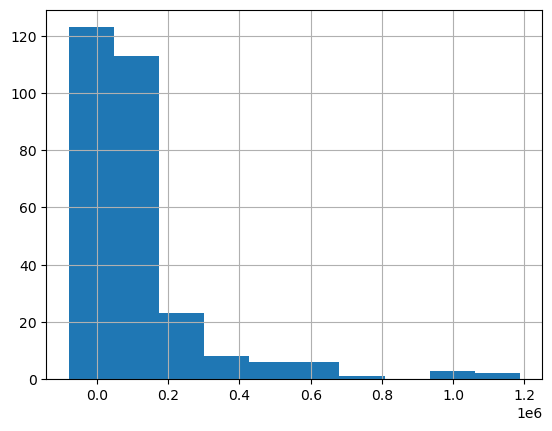

In [28]:
sample.timestamp_diff.hist()

### Question 4:

Do any of the v1 time series for individual serial_numbers have outliers? If so, can you explain the outliers with any of the other data?

It is very important to define what is an outlier. In question 3, the criteria was that it has to follow a timeseries trend with respect to the recorded index. So as new rows appeared we checked if the data was coming as a sequential value. 

In this exercise I will assume the outlier for each serial_number is statistical based on a numerical value. We can start with a magnitude check in regards to v1. A box plot can help us understand. 


<Axes: >

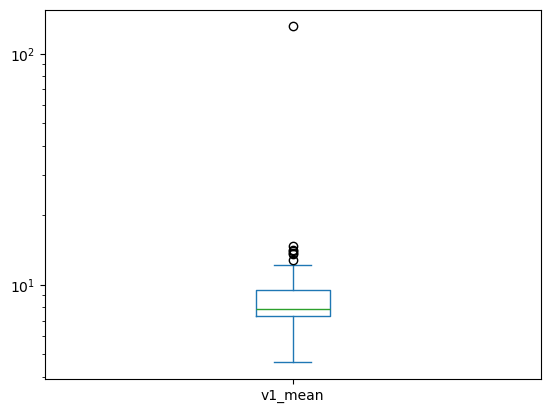

In [29]:
df_agg = df.groupby("serial_number",dropna=True).agg(v1_mean =('v1','mean'),
                                                     v1_std=('v1','std'),
                                                     v2_mean = ('v2','mean'),
                                                     v2_std = ('v2','std') ).reset_index()
df_agg[['v1_mean']].plot(kind='box',logy=True)

We can see that there a few outliers beyond the whiskers and an obvoius outlier.

In [30]:
df_agg.describe()

,v1_mean,v1_std,v2_mean,v2_std
count,1373.000000,1364.000000,1373.000000,1364.000000
mean,8.239102,0.085051,44.998049,1.661141
std,3.545441,0.198251,7.913039,1.258074
min,0.000000,0.000000,0.000000,0.000000
25%,7.309920,0.017829,41.171429,0.915908
50%,7.849333,0.048645,43.500000,1.266979
75%,9.528670,0.098569,49.000000,2.108779
max,131.070007,5.009432,255.000000,23.325080


We can see that there is an obvious ourlier. Let's take a look at the ones which are above the 75 percentile.

In [31]:
df_agg.query('v1_mean>20')

,serial_number,v1_mean,v1_std,v2_mean,v2_std
1356,AZ3P02401A5F,131.070007,0.0,255.0,0.0


Within this simple analysis we of averaging the values of the signals we can very quickly find some of the extreme outliers. 

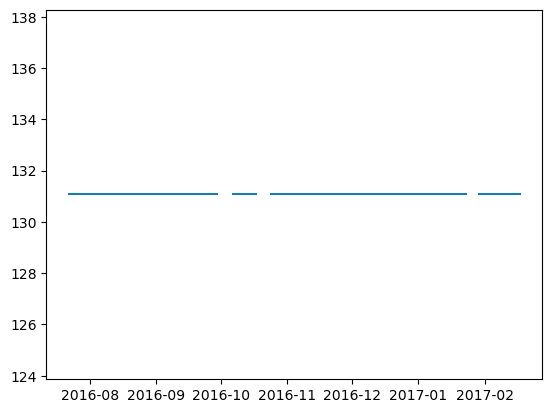

In [32]:
out = df.query("serial_number=='AZ3P02401A5F'")
plt.plot(out.timestamp,out.v1)
plt.show()

Looks like a flat line we very high values

We can investigate with other columns for example v2 and still find some outliers

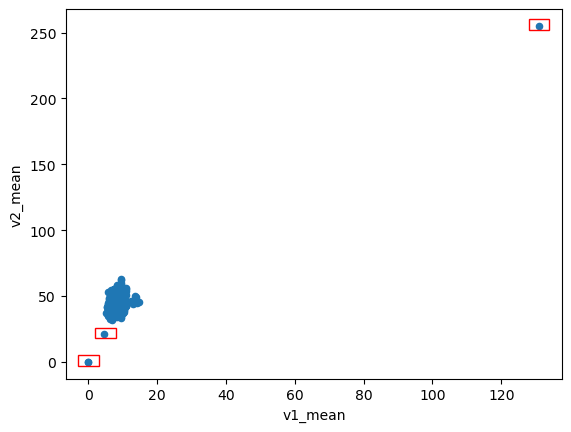

In [33]:
df_agg.plot(x='v1_mean', y='v2_mean',logx=False,logy=False,kind='scatter')
rectangle1 = patches.Rectangle((-3, -3), 6, 8,
                              linewidth=1, edgecolor='r', facecolor='none')
rectangle2 = patches.Rectangle((2, 18), 6, 8,
                              linewidth=1, edgecolor='r', facecolor='none')
rectangle3 = patches.Rectangle((128, 252), 6, 8,
                              linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rectangle1)
plt.gca().add_patch(rectangle2)
plt.gca().add_patch(rectangle3)


plt.show()

It's interesting we found a bit more of outliers sort of sitting on the outer parts of the main blob shown by the red boxes

### Question 5:

Are there any serial_numbers that have a linear trend in v1 over time?

To be able to analyze the linear trends, we can simply convert timestamps into unix values and scale them, then calculate the correlation variable with respect to V1. 

In [35]:
df['unix_timestamp']  = (df.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df['Date'] = (df['unix_timestamp'] - df['unix_timestamp'].min()) / (df['unix_timestamp'].max() - df['unix_timestamp'].min())   

let's calculate the correlation

In [36]:

# Calculate correlation parameter between normalized timestamp and the V1
serial_number = [] 
corr = [] 
for idx,value in df.groupby("serial_number",dropna=True):
    serial_number.append(idx) 
    corr.append(value[['Date','v1']].corr()['Date'].iloc[1])

# Filter out the top varialbles
df_corr = pd.DataFrame(data={'serial_number':serial_number,"linearity":corr}).dropna().sort_values("linearity",ascending=False)
good_ones = df_corr.iloc[0:9]
good_ones


,serial_number,linearity
75,11232W1069,1.000000
494,11425C0092,0.987020
954,11602C0004,0.981431
375,11412C0646,0.977286
312,11409W0370,0.969860
487,11423C0744,0.943397
710,11507W0089,0.935584
639,11435C0338,0.931192
488,11423C0745,0.915045


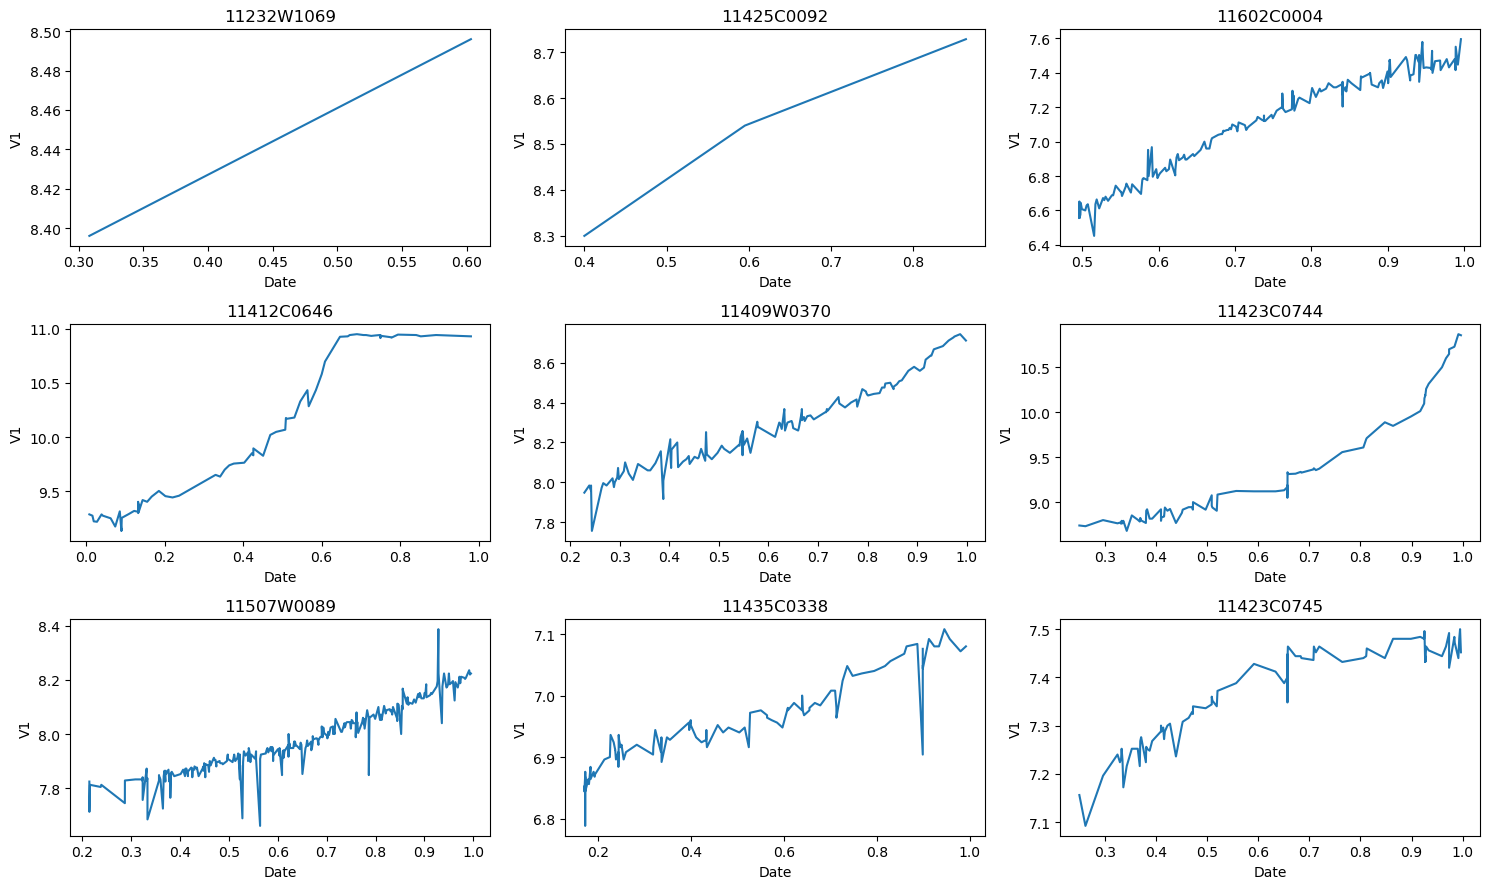

In [37]:
# Visualize
plt.figure(figsize=(15,9))
for idx,feature in enumerate(good_ones.serial_number):
    plt.subplot(3, 3, idx+1)
    x = df.query(f"serial_number =='{feature}'").copy()
    x.sort_values('Date',inplace=True)
    plt.plot(x['Date'],x['v1'],label=i)
    plt.xlabel("Date")
    plt.ylabel("V1")
    plt.title(feature)
plt.tight_layout()
plt.show()

### Question 6:

Propose and implement a method to classify the qualitative shape of the v1 time series for serial_numbers. The classification is left up to you and obviously the higher the granularity in classification the better.

To analyze the qualitative class of each timeseries, we will take into consideration 5 catageories:

- Constant: Time series with values that remain the same or exhibit very little variation over time.
- Stationary Time Series: Time series where statistical properties such as mean, variance, and autocorrelation remain constant over time, indicating no trend or seasonality.
- Seasonal Time Series: Time series that exhibit repeating patterns or cycles at regular intervals, such as daily, weekly, or yearly seasons.
- Cyclic Time Series: Time series that display oscillations or fluctuations with variable cycle lengths, distinct from fixed-frequency seasonality.
- Trending Time Series: Time series showing a systematic, consistent upward or downward movement over time, indicating a trend in the data.

To do this classification we will use the Augmented Dickey-Fuller test, and for seasonality we will check using decomposition scipy package. The process is done in the  **classify_time_series** function imported from above. 

But first we have to understand the sampling regarding the time axis. As we saw earlier that they were not always sequencial with each row, and there can be some sampling non-uniformities. We will calculate the intervals and check the range of the timestamps for each serial_number. We will also take a look if they have duration/range time intersections or wether they are disjoint.

#### Resample analysis

In [39]:
uniques = df.serial_number.unique()
data = {}
summary = { 'serial_number':[],"low_t":[],"high_t":[],'interval':[],'counter':[]}
for sample in uniques:
    x = df.query(f"serial_number =='{sample}'").copy().sort_values('Date')
    data[sample] = x[['Date','timestamp','v1','v2']]

    summary['serial_number'].append(sample)
    summary['low_t'].append(x.Date.min())
    summary['high_t'].append(x.Date.max())
    summary['interval'].append(x.v1.diff().max())
    summary['counter'].append(x.shape[0])

summary = pd.DataFrame(summary)


In [40]:
summary['duration'] = summary.eval('high_t - low_t')

In [41]:
summary.describe()

,low_t,high_t,interval,counter,duration
count,1373.000000,1373.000000,1364.000000,1373.000000,1373.000000
mean,0.213435,0.927988,0.285537,150.587036,0.714553
std,0.257090,0.130991,0.392080,131.895767,0.264232
min,0.000000,0.331525,0.000000,1.000000,0.000000
25%,0.006392,0.946766,0.040000,43.000000,0.499357
50%,0.064989,0.988782,0.180000,106.000000,0.787796
75%,0.387843,0.996600,0.372000,226.000000,0.963601
max,0.933973,1.000000,4.338000,571.000000,0.998195


It's intersting that we can see a variety of samplings and start and end location. Let's also investigate the common time periods to this if they are disjointed or not. I will use the function **intersection_range()**.

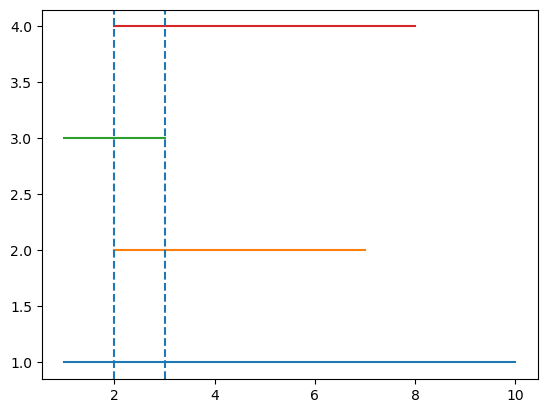

In [42]:
# Example usage:
segments = [(1, 10), (2, 7), (1, 3), (2, 8)]
result = intersection_range(segments)

for idx,value in enumerate(segments):
    plt.plot(value,2*[idx+1])
plt.axvline(result[0],linestyle ='--')
plt.axvline(result[1],linestyle = '--')

In [43]:
# For out database
segments = [ (i,j) for i,j in zip(summary.low_t,summary.high_t)]
result = intersection_range(segments)
print(f"Intersection range -> {result}")

Intersection range -> None


#### Qualitative classification

The time series have different nature in terms of durations and interval spans, so I will have to resample them into a standard value so that the function **classify_time_series** would work. Some trends even within themselves have a variety of intervals. This resample can cause the destruction of some high resolution information. But for sake of this assignment I will not deal with it and later do a visual inspection for the results. We can also see that the durations are disjoint which mean any sort of tabular common time axis algorithm may not neccesary work.

Decomposition requires uniform sampling, now that we know that our temseries are disjoint and randomly sampled, we should take a look to decide the optimal sampling size. We would also want to check the intervals of the timeseries. 

<Axes: >

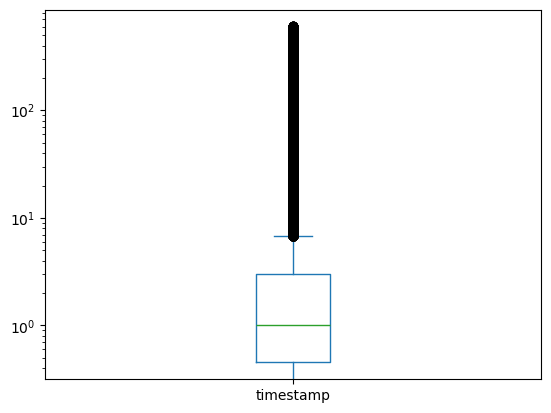

In [44]:
(np.abs(df.timestamp.diff().dt.total_seconds()/(24*3600))).plot(kind='box',logy=True)

We convert the timestamp differences into "days", and the data shows that numbers propagate arround 1 day. 

Let's run it

In [45]:
quality_v1 = {}
quality_v2 = {}
for sample in tqdm(data.keys(),total=len(data)): 

    # Import data and resample to 1 Day
    ts = data[sample].groupby('timestamp').agg({'v1':'mean'})
    ts_series = ts['v1']
    ts_resamp = ts_series.resample('1D').mean()

    # Impute missing dates
    if ts_series.nunique() == 1: 
        ts_resamp[:] = ts_resamp.dropna().unique()[0]
    else: 
        ts_resamp = pd.Series(interpolate(ts_resamp),index=ts_resamp.index)
        
    # CLassify     
    results = classify_time_series(ts_resamp)
    results['ts_resampled'] = ts_resamp
    quality_v1[sample] = results

    # Import data and resample
    ts = data[sample].groupby('timestamp').agg({'v2':'mean'})
    ts_series = ts['v2']
    ts_resamp = ts_series.resample('1D').mean()

    # Impute missing dates
    if ts_series.nunique() == 1: 
        ts_resamp[:] = ts_resamp.dropna().unique()[0]
    else: 
        ts_resamp = pd.Series(interpolate(ts_resamp),index=ts_resamp.index)
        
    # CLassify     
    results = classify_time_series(ts_resamp)
    results['ts_resampled'] = ts_resamp
    quality_v2[sample] = results


  3%|█▏                                       | 41/1373 [00:00<00:27, 49.08it/s]/home/sako/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
 42%|████████████████▋                       | 572/1373 [00:11<00:17, 44.59it/s]/home/sako/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
 47%|██████████████████▉                     | 652/1373 [00:13<00:13, 51.99it/s]/home/sako/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
 63%|█████████████████████████               | 862/1373 [00:17<00:12, 40.80it/s]/home/sako/anaconda3/envs/

Note: Usually processing pipelines are set up in a different way where it will take a dataset implement all the processing in a module and inserted into a data generator fucntion. As we have 1 week for an exploratory analysis, I have made it in functional format while expoloring the questions. Also v2 was added later as I went to the questions one by one taking my time solving each problem at a time. 

In [46]:
summary['ts_type'] = summary.serial_number.map(lambda x: quality_v1[x]['result'])
summary['ts_type'].value_counts(dropna=False).reset_index()

,ts_type,count
0,Trending Time Series,793
1,Seasonal Time Series,450
2,Constant,130


It seems according to this approach we do not have cyclical or stationary

#### Sample of classification result

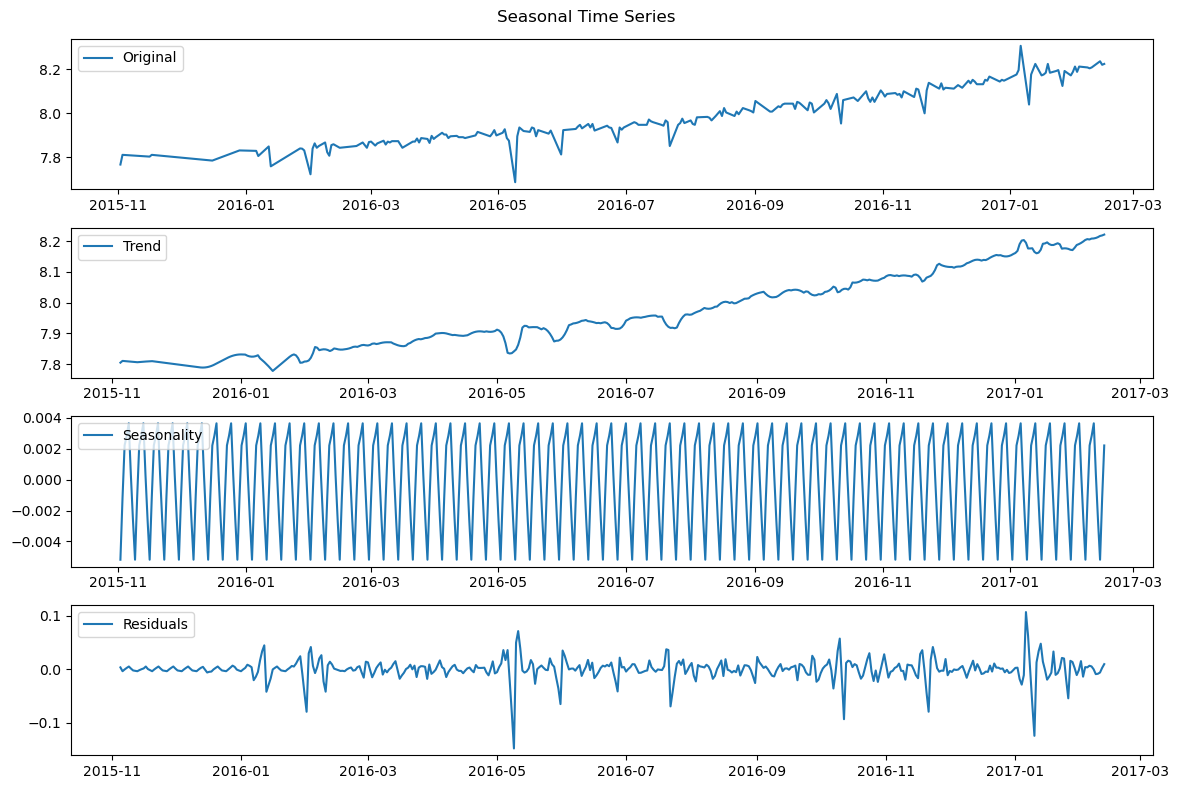

In [47]:
 temp = classify_time_series(quality_v1['11507W0089']['ts_resampled'],visualize=True)

### Question 7:
Assess the performance of the classifier in 6). How would you maximize the performance?

To asses the performance of the classification, we can start by a visual inspection of the results and see if they make sense. Note that at the end we do not have a ground truth. Therefore a direct metric or a loss function can't be created here in that sense. To quantize the results we can use  additional metrics or statistical test which analyze the performance of the decomposer. One way is to test the distribution of the residual which should be a normal distribution using the Shapiro-Wilke test. For the Constant ones, it is easy since it only requires it to have a single flat value, and we simply set the p-value for SW as 0.05. This is also done in the **classify_time_series** function above.

In [48]:
# Normality test
summary['res_p_value'] = summary.serial_number.map(lambda x: quality_v1[x]['p_value_SW'])

In [49]:
((summary.res_p_value)>=0.05).value_counts()

res_p_value
False    1232
True      141
Name: count, dtype: int64

#### Good ones

In [50]:
# Let's choose some good ones.
df_select_good = []
for idx,value in summary.query("res_p_value>=0.05").groupby("ts_type"):
    df_select_good.append(value.sort_values("res_p_value",ascending=False).iloc[:2])
df_select_good = pd.concat(df_select_good)
df_select_good

,serial_number,low_t,high_t,interval,counter,duration,ts_type,res_p_value
1,74611A11021,0.062767,0.630094,0.000,74,0.567326,Constant,0.050000
986,95513E10087,0.667981,0.997400,0.000,38,0.329420,Constant,0.050000
631,11520W0279,0.668850,0.996622,0.196,145,0.327771,Seasonal Time Series,0.201246
633,11520W0280,0.668850,0.996622,0.208,145,0.327771,Seasonal Time Series,0.120341
1192,T1614B0026,0.707990,0.998237,0.128,138,0.290247,Trending Time Series,0.686771
1190,T1614B0021,0.707990,0.998237,0.080,138,0.290247,Trending Time Series,0.653874


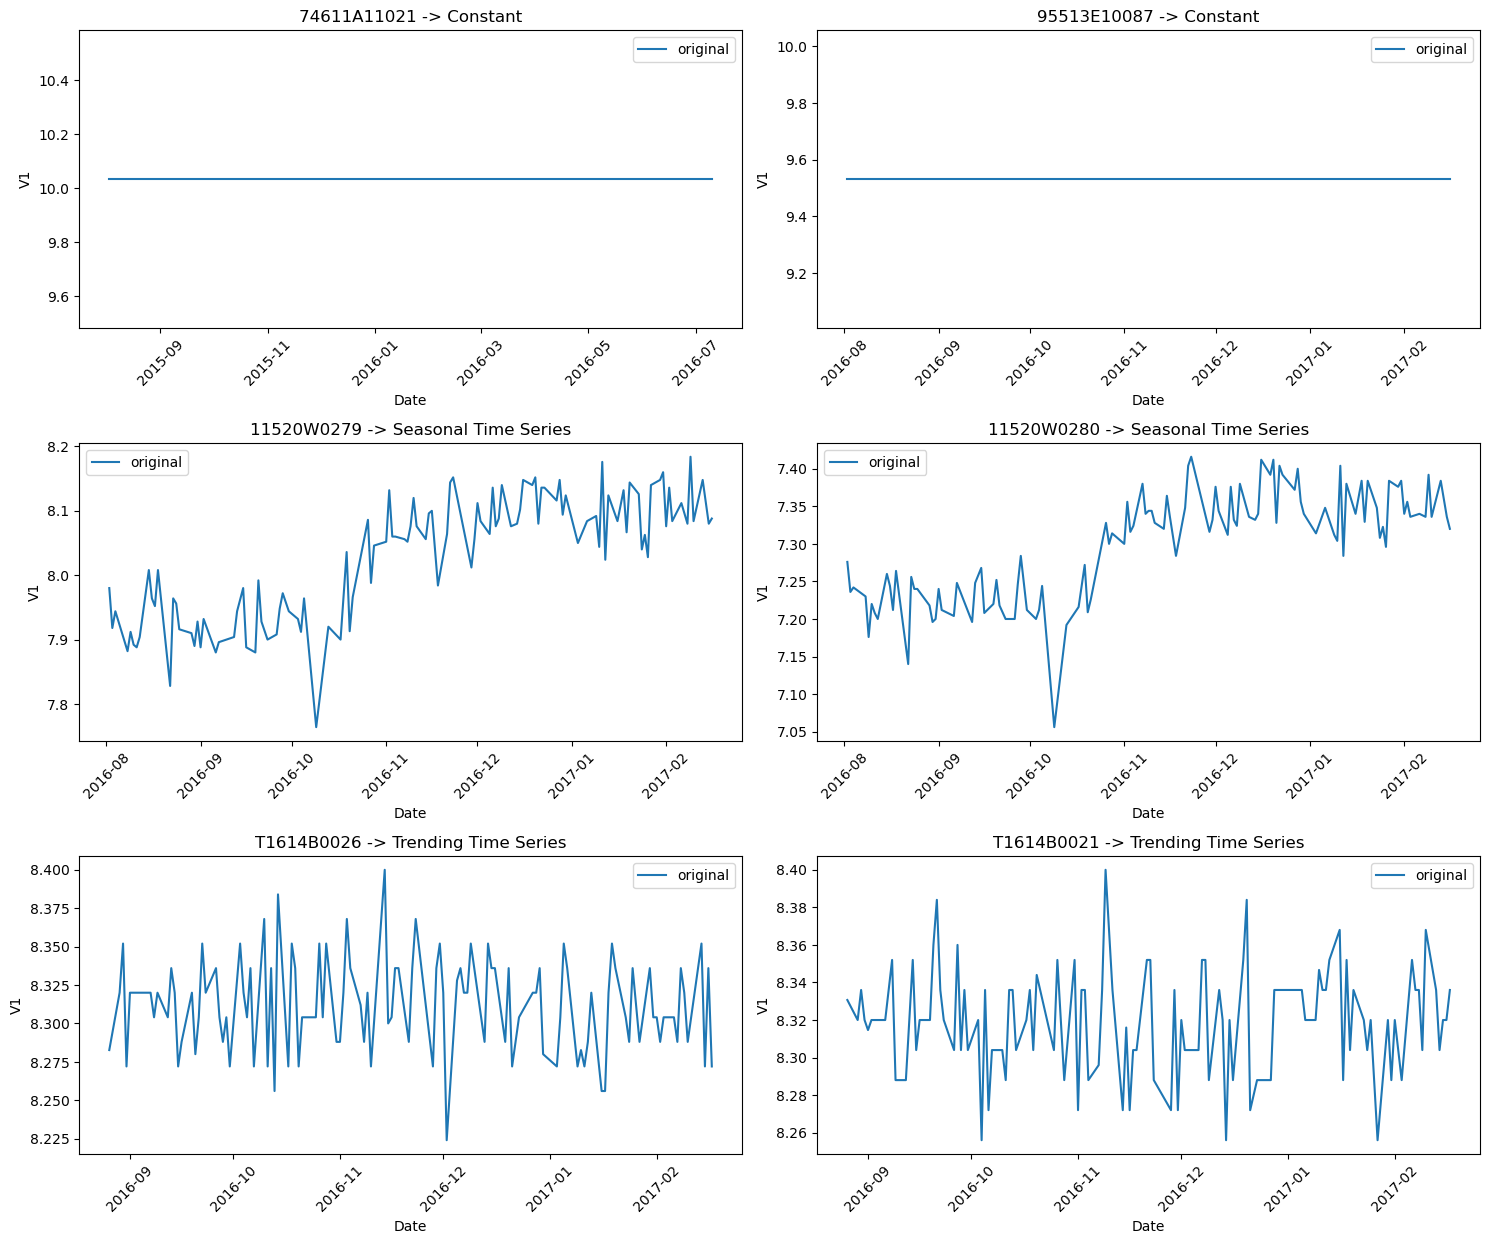

In [51]:

# Visualize
plt.figure(figsize=(15,20))
for idx,feature in enumerate(df_select_good.itertuples()):
    plt.subplot(5, 2, idx+1)

    samp = quality_v1[feature.serial_number]['ts_resampled']
    
    plt.plot(samp.index,samp,label='original')
    plt.xlabel("Date")
    plt.ylabel("V1")
    plt.title(f"{feature.serial_number} -> {feature.ts_type}")
    plt.xticks(rotation=45)
    plt.legend()
    
plt.tight_layout()
plt.show()


#### Bad ones

In [52]:
df_select_bad= []
for idx,value in summary.query("res_p_value<0.05").groupby("ts_type"):
    df_select_bad.append(value.sort_values("res_p_value").iloc[:4])
df_select_bad = pd.concat(df_select_bad)
df_select_bad

,serial_number,low_t,high_t,interval,counter,duration,ts_type,res_p_value
902,11442C1156,0.007027,0.998165,0.004,528,0.991138,Seasonal Time Series,4.352146e-45
108,94311B10059,0.022247,0.956943,0.002,68,0.934695,Seasonal Time Series,6.034084e-45
651,68810L10863,0.001693,0.979918,0.002,113,0.978225,Seasonal Time Series,5.344379e-44
106,94311B10053,0.022247,0.956943,0.002,68,0.934695,Seasonal Time Series,1.151214e-43
129,84414E10140,0.004828,0.998268,0.002,168,0.993440,Trending Time Series,2.054136e-46
305,95513E10003,0.004733,0.991555,0.002,349,0.986823,Trending Time Series,2.749205e-46
812,89713E10144,0.006382,0.989975,0.002,101,0.983593,Trending Time Series,3.169136e-46
351,66013D10218,0.004708,0.993212,0.002,72,0.988503,Trending Time Series,9.260731e-46


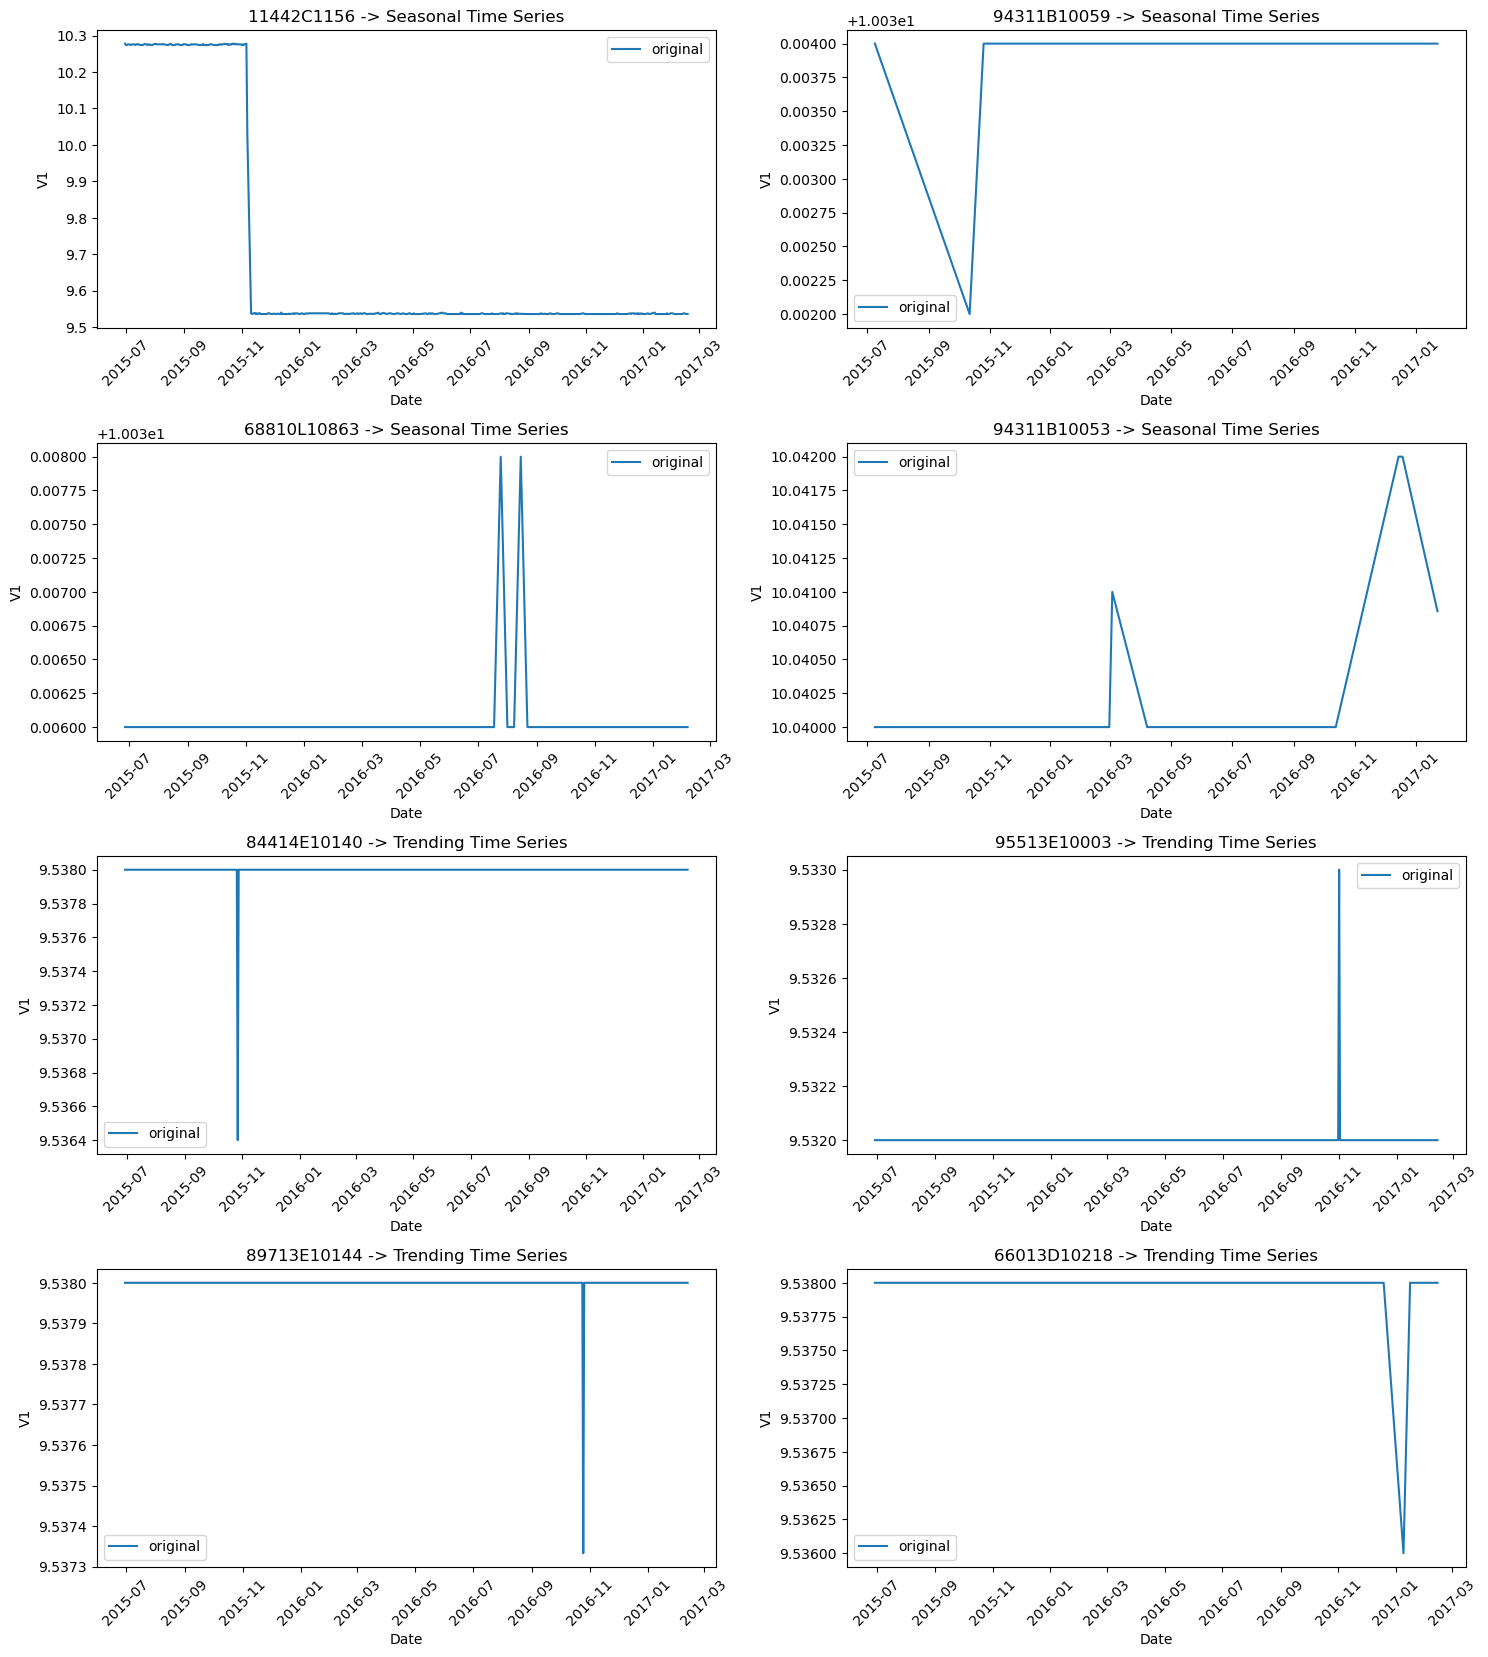

In [53]:

# Visualize
plt.figure(figsize=(15,20))
for idx,feature in enumerate(df_select_bad.itertuples()):
    plt.subplot(5, 2, idx+1)
    samp = quality_v1[feature.serial_number]['ts_resampled']
    plt.plot(samp.index,samp,label='original')
    plt.xlabel("Date")
    plt.ylabel("V1")
    plt.title(f"{feature.serial_number} -> {feature.ts_type}")
    plt.xticks(rotation=45)
    plt.legend()
    
plt.tight_layout()
plt.show()


As we can see that the ones which have a low p-value for SW are weird shapes and have spikes hence there decomposed residuals had low p-values. 

#### Proposed improvements

To answer the second question regarding the improvment of the classification. 

1. For 95513E10003 and 89713E10150 we can see that there is a spike or dirac function structure. He we can apply a sigma clip and it will remove this value and it will be classified as "Constant" 
2. A "step function" classifier category should be added as we can see 11442C1156 (increase garunularity)
3. Fine tune the sampling hyperparameter as we are currently using 1 Day (even though 1 D doesn't seem to distort that much)
4. Using more advanced supervised approaches to classify the data given a simulated sample based on our current samples or labeled data from other datasets (supervised - KNN style algorithms).  

### Question 8:
For serial_number 11410W0294, can you characterize the noise in v1?

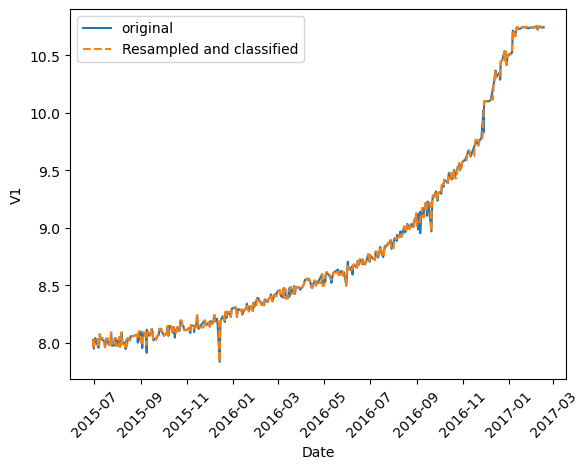

In [54]:
ts = df.query("serial_number == '11410W0294'")[['v1','timestamp']]
ts = ts.set_index('timestamp')
ts_resamp = ts.resample('1D').mean().ffill().bfill()


plt.plot(ts.index,ts,label='original')
plt.plot(ts_resamp.index,ts_resamp,"--",label='Resampled and classified')
plt.xlabel("Date")
plt.ylabel("V1")
plt.xticks(rotation=45)
plt.legend()

In [55]:
sample = quality_v1['11410W0294']

res = pd.DataFrame({'seasonal':sample['seasonal_component'],
                   'trend':sample['trend_component'],
                   'residual':sample['residual_component']})

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

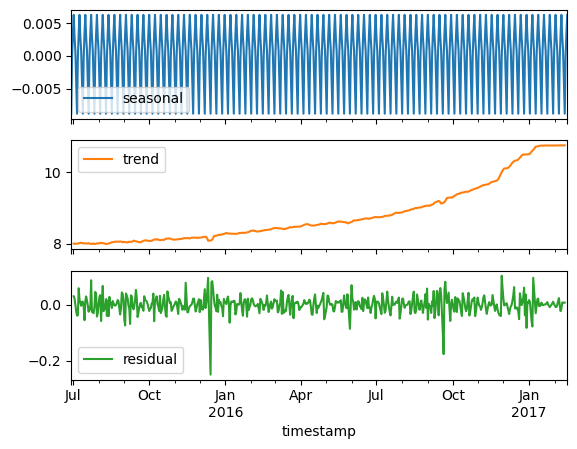

In [56]:
res.plot(subplots=True)

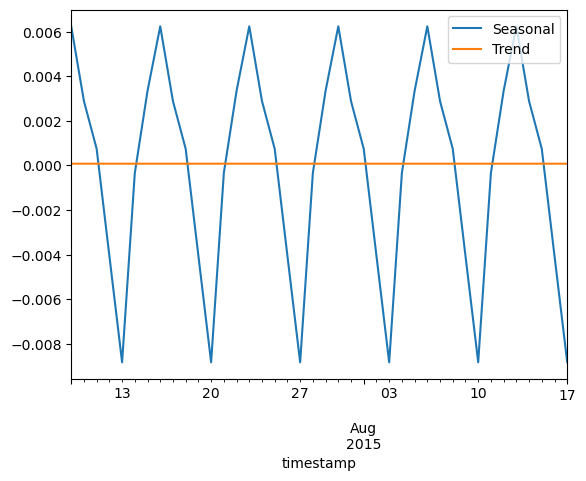

In [57]:
ax = res['seasonal'].iloc[10:50].plot(label='Seasonal')
(res['trend'].iloc[10:50]/100000 ).plot(ax=ax,label='Trend')
plt.legend()
plt.show()

Compared to the trend seems like we do have a 6 day seasonality and the trend seems to be flat

array([[<Axes: title={'center': 'seasonal'}>,
        <Axes: title={'center': 'trend'}>],
       [<Axes: title={'center': 'residual'}>, <Axes: >]], dtype=object)

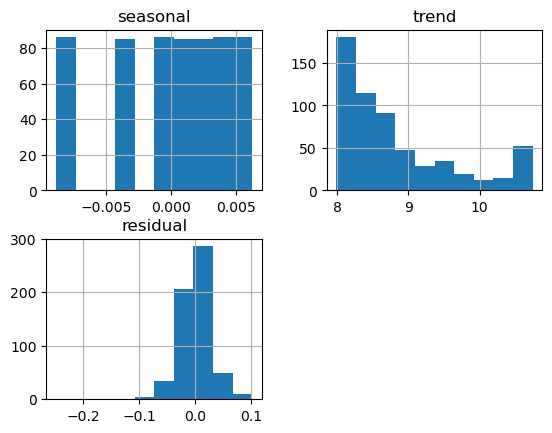

In [58]:
res.hist()

The residual which is the noise with respect to the trends and seasonality seems to be quite normal. 

In [59]:
summary.query("serial_number =='11410W0294'")

,serial_number,low_t,high_t,interval,counter,duration,ts_type,res_p_value
225,11410W0294,0.004766,0.9966,0.344,394,0.991834,Seasonal Time Series,1.538364e-18


It's interesting that out linearity test shows that the value is quite linear but the trend breaks at the end to a plateau, it shows to be both seasonal due to the oscillations and the shapiro wilke test says the residual is normal. I would say here the noise is simply white. I have no idea from what machine or system this data is coming from. There are 2 distict spike which I think a sigma clip and a exponential fit would resolve up to the end plateau. 

### Question 9:
How many serial_numbers have a v1 with a qualitative shape like serial_number 11410W0294?

11410W0294 is considered as a linear trend with Seasonality 

In [60]:
summary = pd.merge(summary,df_corr,on='serial_number',how='outer')

In [61]:
summary.linearity.fillna(0,inplace=True)

In [62]:
total_look = summary.query("linearity >0.9 and res_p_value<0.5 and ts_type=='Seasonal Time Series'")
total_look

,serial_number,low_t,high_t,interval,counter,duration,ts_type,res_p_value,linearity
189,11232W1069,0.308291,0.603409,0.100,2,0.295118,Seasonal Time Series,3.908099e-19,1.000000
225,11410W0294,0.004766,0.996600,0.344,394,0.991834,Seasonal Time Series,1.538364e-18,0.912944
408,11412C0646,0.008597,0.980038,0.228,81,0.971441,Seasonal Time Series,7.471567e-39,0.977286
540,11435C0338,0.170555,0.991508,0.172,113,0.820953,Seasonal Time Series,7.911638e-30,0.931192
637,11602C0004,0.496259,0.995616,0.232,191,0.499357,Seasonal Time Series,9.717982e-11,0.981431
750,11409W0370,0.228659,0.998236,0.216,124,0.769576,Seasonal Time Series,1.801015e-27,0.969860
818,11507W0089,0.214263,0.995227,0.212,311,0.780964,Seasonal Time Series,2.797768e-24,0.935584
1043,11423C0744,0.250425,0.996514,0.236,86,0.746089,Seasonal Time Series,6.059052e-27,0.943397
1044,11423C0745,0.250425,0.996514,0.104,86,0.746089,Seasonal Time Series,1.881085e-30,0.915045
1225,25512E10040,0.457295,0.898538,0.002,3,0.441243,Seasonal Time Series,2.305179e-32,0.908286


In [63]:
total_look.shape

(11, 9)

If we consider linearity above 0.5 that we can have more ... 

In [64]:
summary.query("linearity >0.5 and res_p_value<0.5 and ts_type=='Seasonal Time Series'").shape

(107, 9)

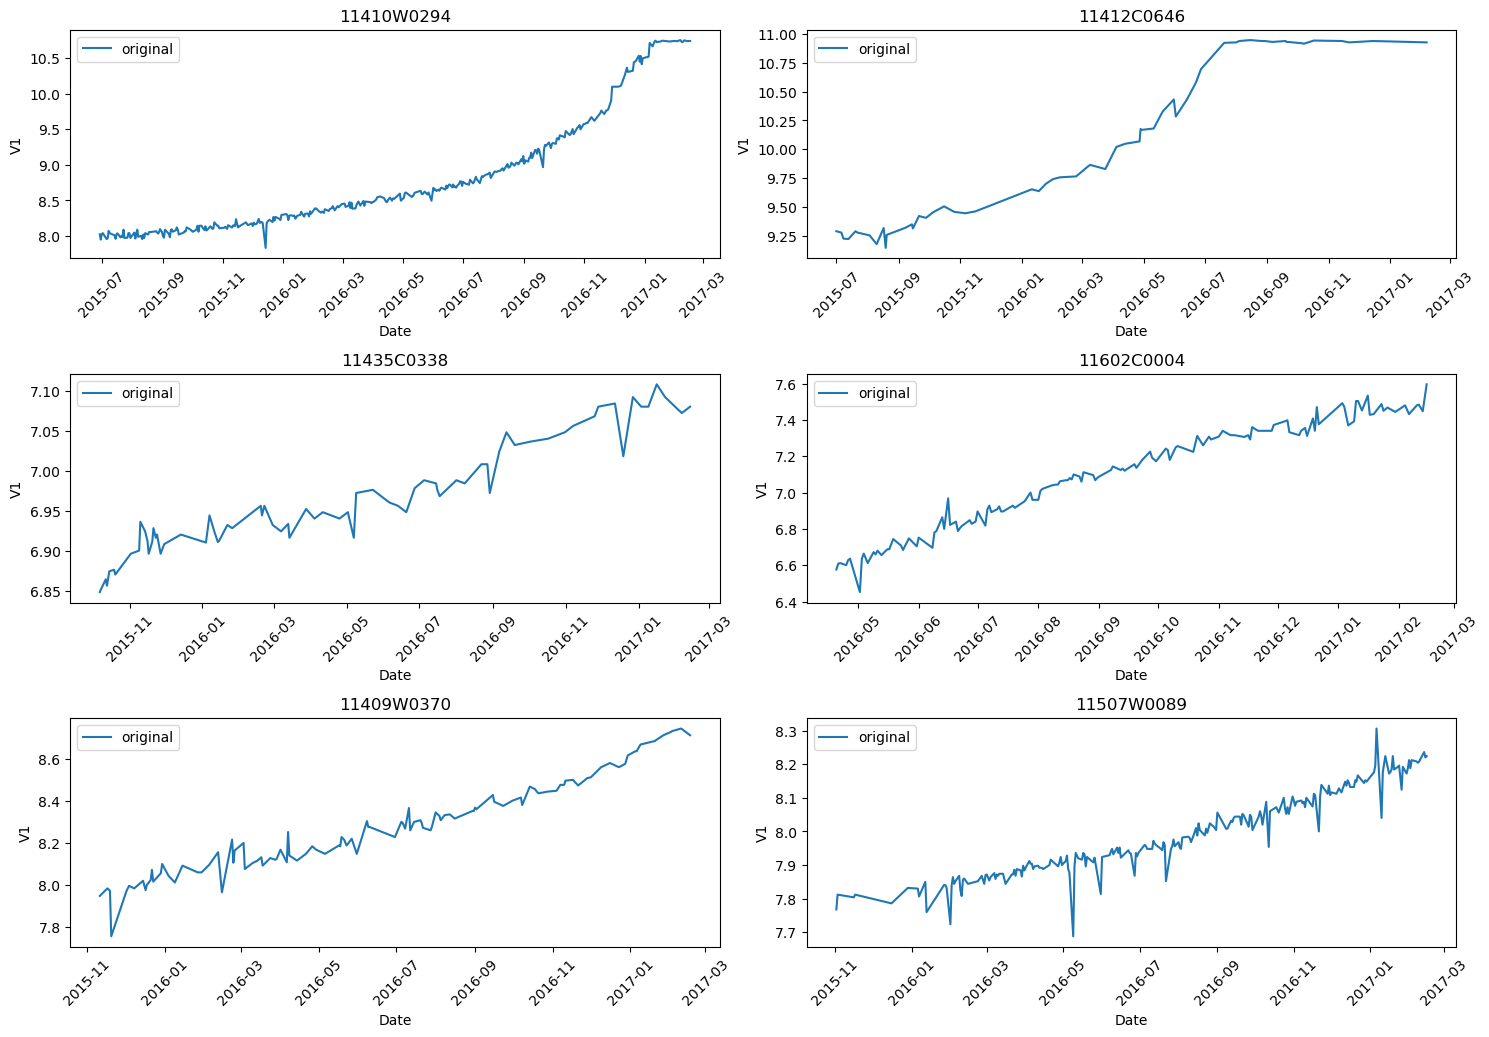

In [65]:
# Filter some 
df_lookalike = total_look.query('counter > 3').iloc[0:6]

# Visualize
plt.figure(figsize=(15,20))
for idx,feature in enumerate(df_lookalike.itertuples()):
    plt.subplot(6,2, idx+1)
    
    samp = quality_v1[feature.serial_number]['ts_resampled']

    plt.plot(samp.index,samp,label='original')
    plt.xlabel("Date")
    plt.ylabel("V1")
    plt.title(f"{feature.serial_number}")
    plt.xticks(rotation=45)
    plt.legend()
    
plt.tight_layout()
plt.show()


### Question 10:
If there are no other serial_numbers with a qualitative shape like serial_number 11410W0294, can you create a machine learning model to predict time to reach the horizontal clipping that occurs at the end of the time series? If there are other serial_numbers with a qualitative shape like 11410W0294, can you create a machine learning model to predict the time to reach the horizontal clipping?

The algorithm we will design contains 3 stages:

1. A tool for classifying which part of the time series are a plateau
2. Predicting the new parts of a time series
3. Use the plateau classification tool to calculate the time from the most recent date to the end begining of the plateau which will be the prediction for the time needed to arrive to a horizontal clip.

#### 1. Clustering of plateaus

To reach to horizontal clip point, we will consider clustering the time series using Kmeans. By calculating at it's moving window difference and the respective value these should be grouped into classes. Very low similar change values should be considered a plateau for clipoff. The moving window allows for distance differentiation sometimes the jumps can very quite alot between consequitive points. This may not be always true, but since we are looking for end of curve cuttoffs, the smallest change in the signal at the end might indicate this or can be a false positive, but that can only be known with back-testing.  

In the previous step we sampled the data into a single day and we were able to interpolate the values. A quick visual check proved that the data was not distorted exteremly but still further analysis would be required to finalize this claim. 

After labeling these sections, we will calculate the duration of the plateau at the end of the timeseries. If there is a plateau at the end, we will assume it clipped and the duration will be a label for our ML algorithm.  


In [66]:
smoothed = {}
gradient = {} 
serial_number_s = sorted(summary.query("ts_type!='Constrant' and counter>2").serial_number.tolist())

smooth_dur_dict= {}
for serial_number in tqdm(serial_number_s,total=len(serial_number_s)):
    
    ts = quality_v1[serial_number]['ts_resampled']
    smooth_dur = round(ts.shape[0]/5)
    smooth_dur_dict[serial_number] = smooth_dur
    
    if ts.shape[0] >= 2: 

        # Smooth the data 
        value_s = SF(ts.tolist(),window_length=smooth_dur,polyorder=2)
        smoothed[serial_number] = pd.Series(value_s,index=ts.index)
        
        
        # clustering
        if ts.nunique()==1:
            pass
            
        else:  
            cluster_size = round(ts.shape[0]/10)
            if cluster_size > 35 : cluster_size = 30 
        
            # Implement clustering 
            plateau =  plateau_clustering(ts.index,value_s,window_size=2,n_clus=cluster_size)
        
            # Label horizontal cuttoff
            plateau['cutoff'] = 0
            if plateau.iloc[-smooth_dur:].plateau.mean()==1 : 
                plateau.loc[plateau.iloc[-smooth_dur:].index,'cutoff'] = 1 
        
            # save results
            gradient[serial_number] = plateau


100%|███████████████████████████████████████| 1363/1363 [01:19<00:00, 17.07it/s]


Let's create a summary column for the ones that have a cuttoff and smoothness window 

In [67]:
cuts = [] 
smoothness = [] 
serial_number_s = gradient.keys()

for i in serial_number_s:
    
    plateau = gradient[i].copy()
    smooth_dur = round(plateau.shape[0]/5)
    smoothness.append(smooth_dur)
    
    if len(plateau)>2:
        if plateau.iloc[-smooth_dur:].plateau.mean()==1 : 
            cuts.append(1)
        else:
            cuts.append(0)
    else:
        cuts.append(0)

cuts = pd.DataFrame({'serial_number':serial_number_s,'cutoff':cuts,'smooth_win':smoothness})        
summary_final = pd.merge(summary,cuts,on='serial_number')
summary_final.cutoff.value_counts()

cutoff
0    1189
1      53
Name: count, dtype: int64

In [68]:
summary_final

,serial_number,low_t,high_t,interval,counter,duration,ts_type,res_p_value,linearity,cutoff,smooth_win
0,11149C0428,0.062767,0.630094,0.560,73,0.567326,Trending Time Series,2.460463e-34,-0.130128,0,69
1,74611A11018,0.062767,0.630094,0.002,74,0.567326,Trending Time Series,4.710992e-29,-0.184766,0,69
2,25412E10121,0.062767,0.630094,0.002,74,0.567326,Trending Time Series,1.647333e-36,-0.140874,0,69
3,25412E10127,0.062767,0.630094,0.002,74,0.567326,Trending Time Series,1.982850e-27,-0.269543,0,69
4,11344W0098,0.041558,0.913852,0.676,75,0.872294,Trending Time Series,7.986884e-40,-0.210629,0,105
...,...,...,...,...,...,...,...,...,...,...,...
1237,11232W0639,0.004705,0.998184,0.856,284,0.993479,Trending Time Series,1.162777e-34,-0.135971,0,120
1238,11232W0638,0.004705,0.998184,0.884,284,0.993479,Trending Time Series,6.045707e-35,-0.167475,0,120
1239,11539C0054,0.449577,0.995270,0.180,143,0.545693,Trending Time Series,3.645768e-10,0.193354,0,66
1240,11539C0057,0.449577,0.995270,0.180,143,0.545693,Trending Time Series,2.246229e-10,0.381973,0,66


In [69]:
selection = ['11418R0166','95112G10030','3410 DA87430310','68810L10964','11409W0250','11507W0198',
 '11442C1156','75113E10236','11425C0233','11514C0177','11545C0198','T1628B0331','11435C0154',
 '11514C0272','11418R0170','11410W0294','11352W0113','11430C0697']

In [70]:
with_cuts = summary_final.query("ts_type!='Constant' and cutoff==1").sample(9)
without_cuts = summary_final.query("ts_type!='Constant' and cutoff==0").sample(9)
checker = pd.concat([with_cuts,without_cuts])


Let's visualize the plateaus with respect to the different type of cutoff labels and trend types.

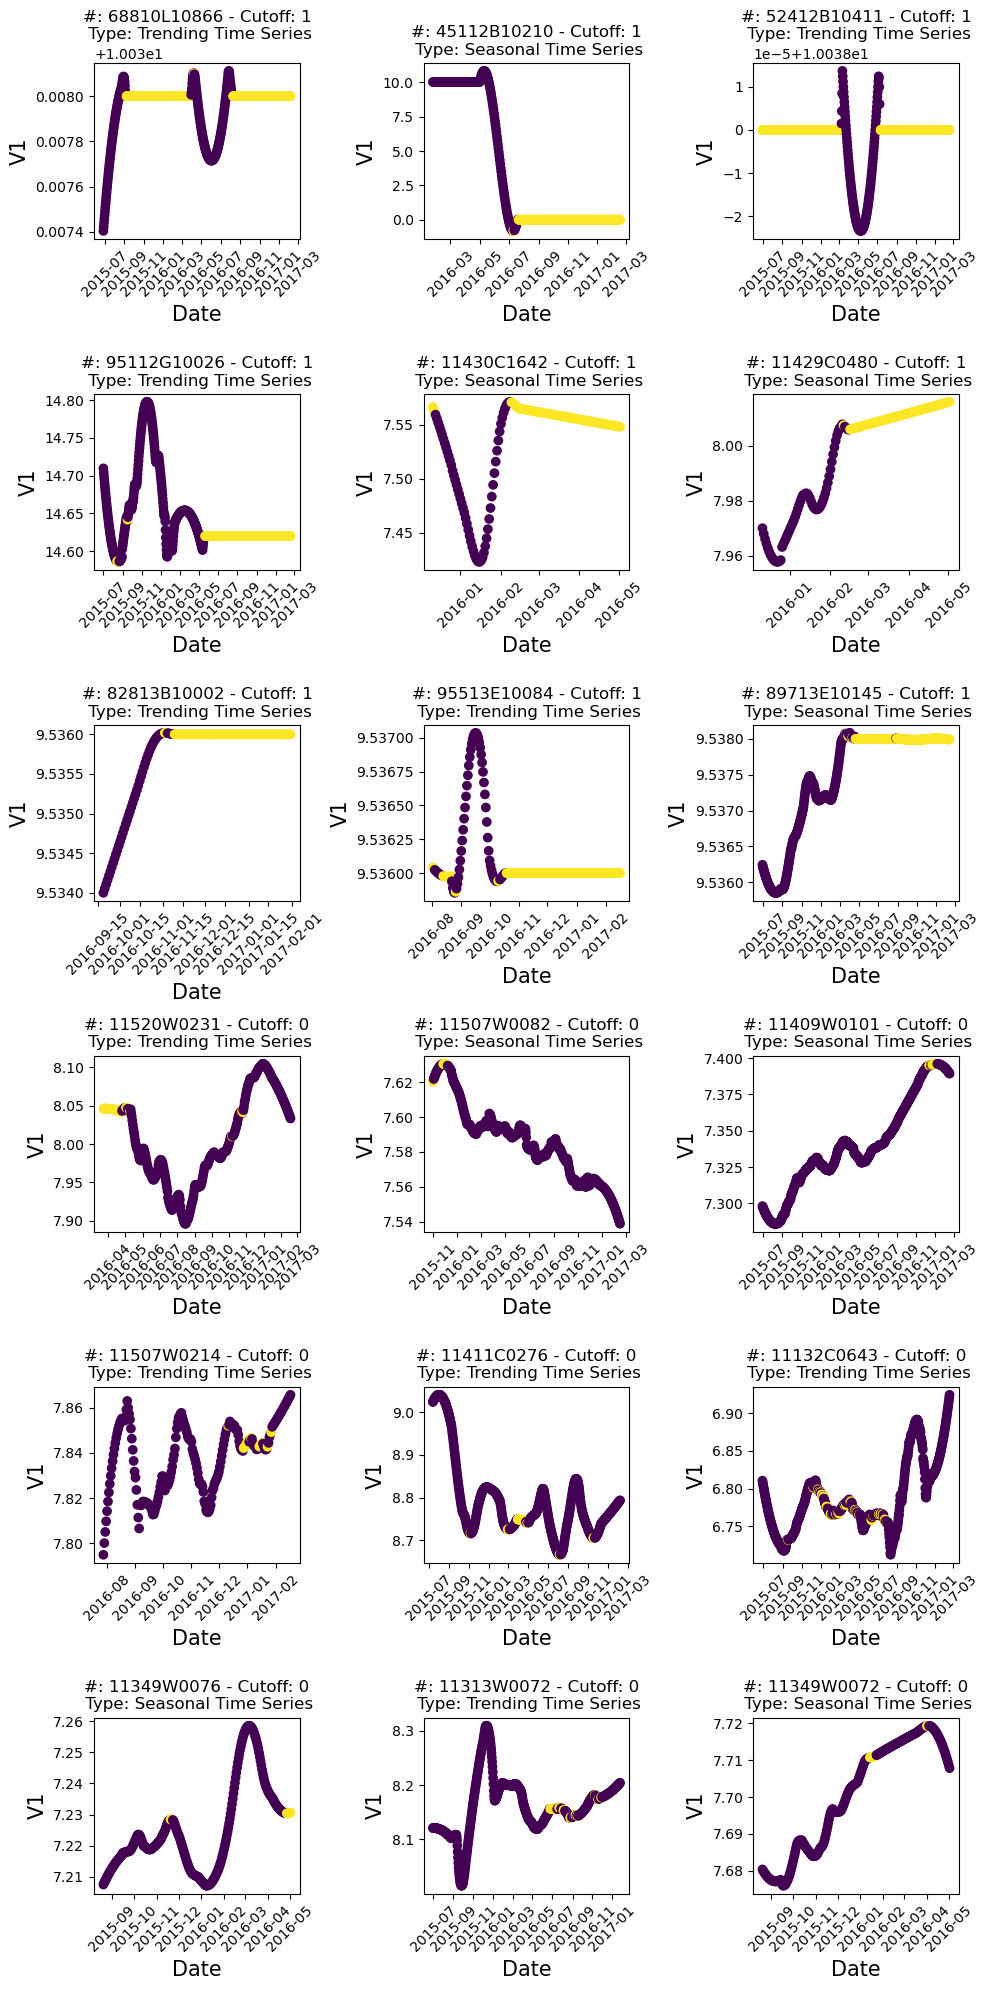

In [71]:

# Visualize
plt.figure(figsize=(10,20))
counter = 0
for feature in checker.itertuples():
    grad = gradient[feature.serial_number]  
        
    plt.subplot(6,3, counter+1) 
    plt.scatter(grad.x,grad.orig_y,c=grad.plateau) 
    plt.xlabel("Date",fontsize=15)
    plt.ylabel(r"V1",fontsize=15)
    plt.xticks(rotation=45)
    plt.title(f"#: {feature.serial_number} - Cutoff: {feature.cutoff}\n Type: {feature.ts_type}")   
    counter = counter + 1

plt.tight_layout()
plt.show()

Visual inspection shows that there are well categorized pleteaus and some are not. Also there are some plateaus that have been affected by noise which might need be smoothed more.  

#### 2. Predicting the timeseries

LSTM are a good type of recurrent neural networks for their ability to ingest sequential time series data with variable size. As we have already matched the sampling size into 1 day it should assuming that the increments are unified. The relu activation functions will cause the zeros to be returned as zeros hence the zero padding on the disjointed dates might help us.   

**Preporcess**

In [72]:
# Estimate the common date the maximum size of the input layer
common_dates = pd.date_range(start= min(df.x.min() for df in gradient.values()), end=max(df.x.max() for df in gradient.values()), freq='D')
common_dates = pd.DataFrame(data=common_dates,columns=['x'])
training_serial_num = sorted(gradient.keys())

# Normalize per timeseries
database = [] 
for serial_number in training_serial_num:
    ts = gradient[serial_number].orig_y
    ts = 1+((ts - ts.min())/(ts.max()-ts.min()))
    database.append(ts.tolist())

X = np.nan_to_num(pad_sequences(database,dtype= float,value=np.nan))
print_info(f"Max size of input: {common_dates.shape[0]}")

# Reshape
X_reshaped = X.reshape(-1, X.shape[1], 1)

# Split the data into training and validation sets (e.g., 80% training, 20% validation)
split_ratio = 0.8
split_index = int(split_ratio * len(X_reshaped))

X_train, X_val = X_reshaped[:split_index], X_reshaped[split_index:]



[INFO]: Max size of input: 604 



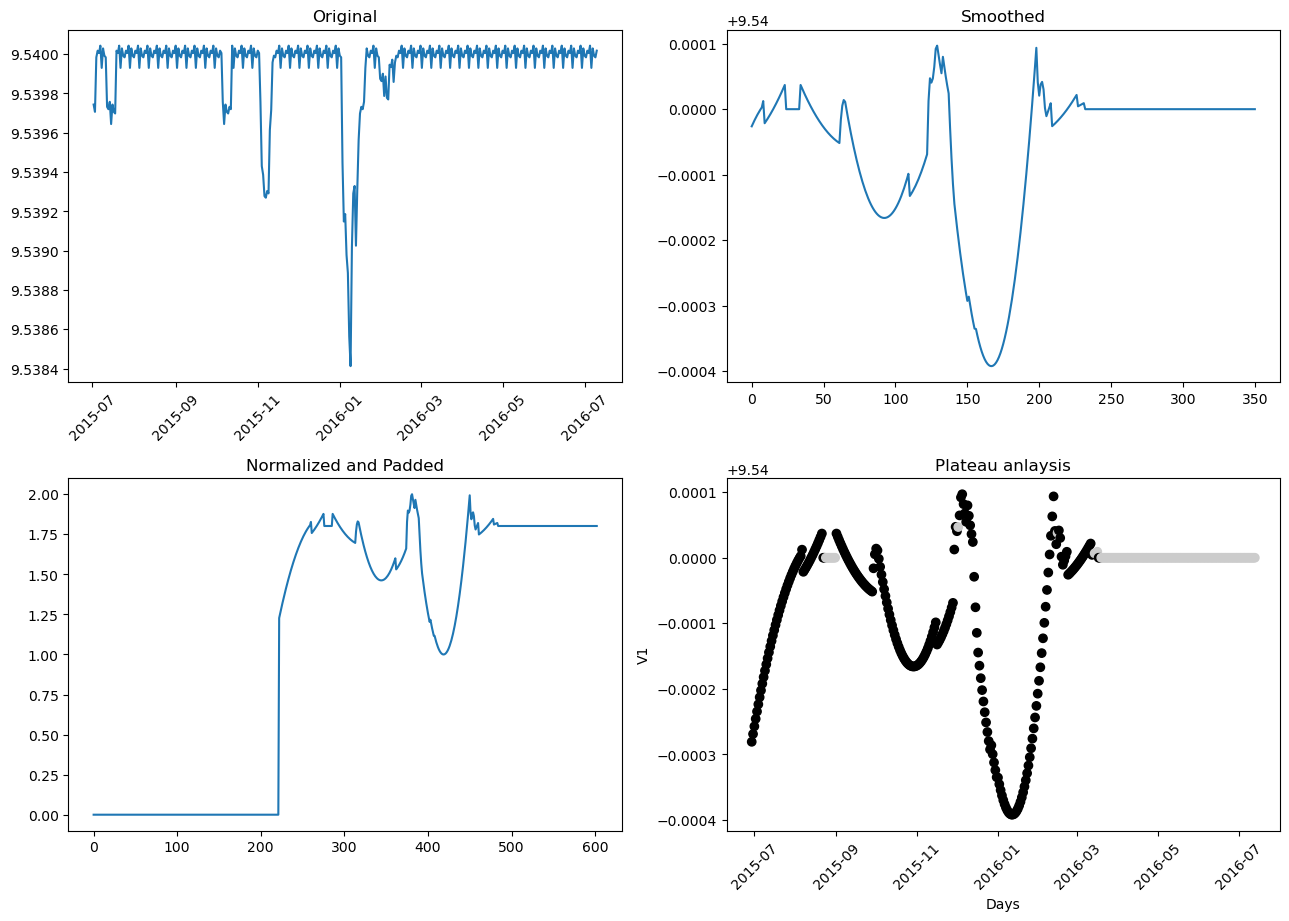

In [73]:
serial_number = '95513E10133'
iter = training_serial_num.index(serial_number)

plt.figure(figsize=(13,13))

plt.subplot(3,2,1)
orig=(quality_v1[serial_number]['trend_component'] + quality_v1[serial_number]['seasonal_component'])
plt.plot(orig)
plt.xticks(rotation=45)
plt.title("Original")


plt.subplot(3,2,2)
plt.plot(gradient[serial_number].orig_y.to_numpy()[30:])
plt.title('Smoothed')


plt.subplot(3,2,3)
plt.plot(X[iter])
plt.title("Normalized and Padded")



res = gradient[serial_number]
plt.subplot(3,2,4)
plt.scatter(res.x,res.orig_y,c=res.plateau,cmap='nipy_spectral')
plt.xlabel('Days')
plt.ylabel('V1')
plt.xticks(rotation=45)
plt.title("Plateau anlaysis")

plt.tight_layout()
plt.show()




**Model training**

In [74]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=( X.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(32))  # Final LSTM layer without return_sequences=True
model.add(Dense(16, activation='relu'))  # Dense layer with ReLU activation
model.add(Dense(1))  # Output layer for regression (single value output)
model.compile(optimizer=Adam(), loss='mean_squared_error')
model.summary()

2024-05-01 19:53:40.742723: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-05-01 19:53:41.000935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:53:41.003263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:53:41.0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 603, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 603, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 603, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 603, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 1

2024-05-01 19:53:41.353964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:53:41.355415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:53:41.356247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Since we are trying to do regression, we will pass to the LSTM itself for training and validation, sort of an autoencoder like training

In [75]:
# Train the LSTM model
history = model.fit(X_train, X_train, 
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val, X_val))

Epoch 1/5


2024-05-01 19:53:41.773069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:53:41.775407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:53:41.776910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - ETA: 0s - loss: 0.6375

2024-05-01 19:54:40.187227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:54:40.188660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:54:40.189814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 63s 2s/step - loss: 0.6375 - val_loss: 0.5231
Epoch 2/5
32/32 [==============================] - 57s 2s/step - loss: 0.5046 - val_loss: 0.5317
Epoch 3/5
32/32 [==============================] - 69s 2s/step - loss: 0.5039 - val_loss: 0.5233
Epoch 4/5
32/32 [==============================] - 61s 2s/step - loss: 0.5044 - val_loss: 0.5216
Epoch 5/5
32/32 [==============================] - 71s 2s/step - loss: 0.5052 - val_loss: 0.5325


#### 3. Inference, clustering, and estimation of Time to cutoff

Let's predict further points

In [76]:
# select a sample 
iter = 20
sample = X[iter]
test_run =  50
test_run

# Run prediction 
y_test = [] 
sample = sample.reshape(-1)
for i in range(test_run):
    temp = sample[i:].copy()
    temp = np.nan_to_num(pad_sequences([temp],dtype= float,value=np.nan,maxlen=X.shape[1])).reshape(-1)     
    y_temp = model.predict(np.expand_dims(temp, axis=0),verbose=False)
    sample = np.append(sample,y_temp)
    y_test.append(y_temp)

y_test = np.array(y_test).reshape(-1)


smooth_dur = test_run//5
res = plateau_clustering(range(len(y_test)),y_test,window_size=2,n_clus=smooth_dur)
has_cut = None
if len(res)>2:
    if res.iloc[-smooth_dur:].plateau.mean()==1 : 
        has_cut = True
    else:
        has_cut=False
else:
    has_cut = False
    
if has_cut : 
    Days = np.argwhere(np.gradient(res.plateau)==0.5)[-1][0]
    print_info(f"In {Days} days we will have a cutoff")
else: 
    print_info("No cuttoff")



2024-05-01 19:59:02.696724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:59:02.698499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:59:02.699792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


[INFO]: In 36 days we will have a cutoff 



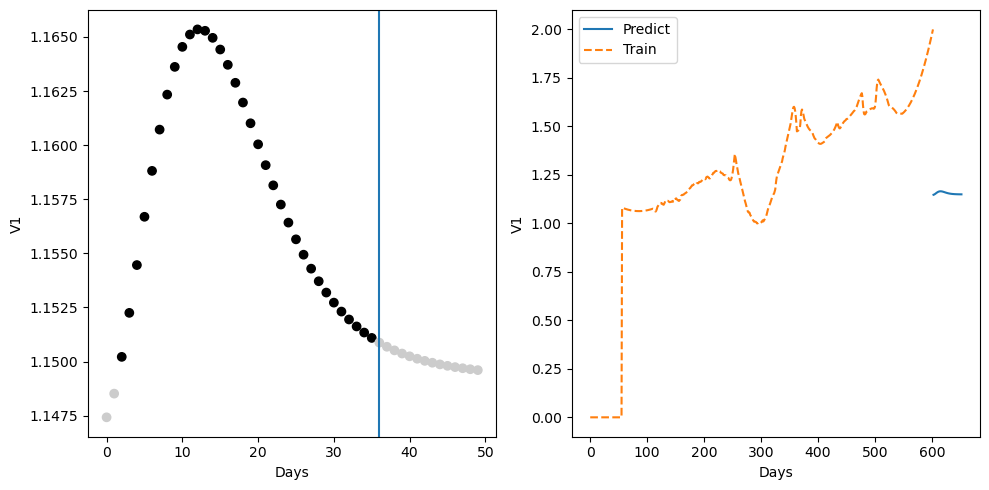

In [77]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(res.x,res.orig_y,c=res.plateau,cmap='nipy_spectral')
if has_cut : 
    plt.axvline(np.argwhere(np.gradient(res.plateau)==0.5).flatten()[-1])
plt.xlabel('Days')
plt.ylabel('V1')

plt.subplot(1,2,2)
plt.plot(range(len(X[iter]),len(X[iter])+test_run),list(y_test),label='Predict')
plt.plot(X[iter],'--',label='Train')
plt.xlabel('Days')
plt.ylabel('V1')
plt.legend()

plt.tight_layout()
plt.show()

### Question 11:
 Assess the performance of the model/s in 10).

The first assesment is to taken a look at the training and validation with respect to the epochs. We only trained with a few epochs without hyperparamter tuning due to the lack of time and computation power.

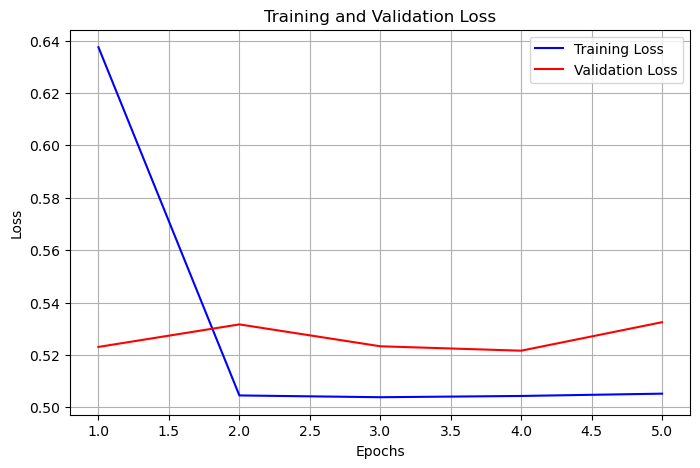

In [78]:
# Extract loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training loss vs. validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Our numbers are arround 1 to 2. Having a mean square of 0.64 ($\sqrt{0.58}=0.76$) means it is still high but within reasonable magnitudes. This indicates that our initial step for predicting the signals is valid and we need to improve the model as a total

In [79]:
df['v1'].describe()

count    206230.000000
mean          8.109349
std           2.386084
min           0.000000
25%           7.248000
50%           7.816000
75%           9.284000
max         131.070007
Name: v1, dtype: float64

**Backtesting** 

Another experiment one can do is backtesting. Which actually proves the true efficiency when evem mean square metric is very high. We can infere previous values in with respect to those steps and see how the network performs. We will pass historical values assuming that we don't have current values, and try to repredict. This tells you if during time, the model was able to generalize on historical times.

In [80]:
checker

,serial_number,low_t,high_t,interval,counter,duration,ts_type,res_p_value,linearity,cutoff,smooth_win
591,68810L10866,0.001693,0.979918,0.002,113,0.978225,Trending Time Series,1.474724e-42,0.069740,1,118
960,45112B10210,0.353402,0.997762,0.000,286,0.644361,Seasonal Time Series,3.097813e-37,-0.826920,1,78
954,52412B10411,0.004817,0.998295,0.002,538,0.993479,Trending Time Series,4.483394e-45,-0.010032,1,120
388,95112G10026,0.010506,0.998067,0.512,226,0.987561,Trending Time Series,1.336473e-39,-0.227044,1,119
439,11430C1642,0.279016,0.515557,0.072,10,0.236541,Seasonal Time Series,3.817028e-21,-0.056621,1,29
432,11429C0480,0.279016,0.515557,0.040,10,0.236541,Seasonal Time Series,9.249875e-19,0.061399,1,29
868,82813B10002,0.747791,0.970461,0.002,5,0.222670,Trending Time Series,2.668957e-22,0.666149,1,27
890,95513E10084,0.667981,0.997400,0.002,38,0.329420,Trending Time Series,3.757960e-25,-0.115953,1,40
727,89713E10145,0.006382,0.989975,0.002,101,0.983593,Seasonal Time Series,4.005178e-38,0.721116,1,119
228,11520W0231,0.450902,0.998217,0.312,190,0.547315,Trending Time Series,1.312548e-17,0.332432,0,66


**Labeled as cutoff**

(603,) (450,) 100


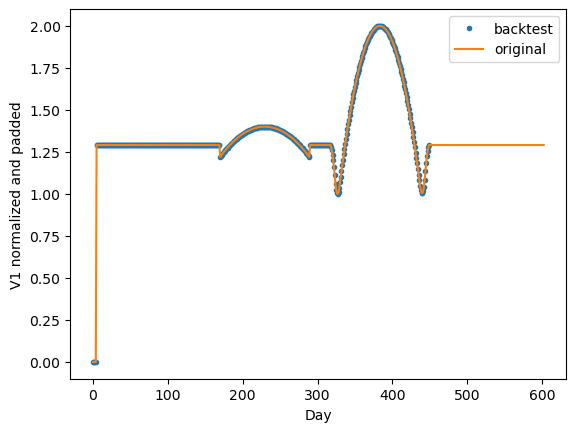

In [81]:
# select a sample 
iter = training_serial_num.index('50012E10016')
sample_orig = X[iter]
sample = sample_orig[:450]
test_run =  100
print(sample_orig.shape,sample.shape,test_run)

plt.plot(sample,'.',label='backtest')
plt.plot(sample_orig,label='original')
plt.xlabel('Day')
plt.ylabel('V1 normalized and padded')
plt.legend()
plt.show()


[INFO]: No cuttoff 



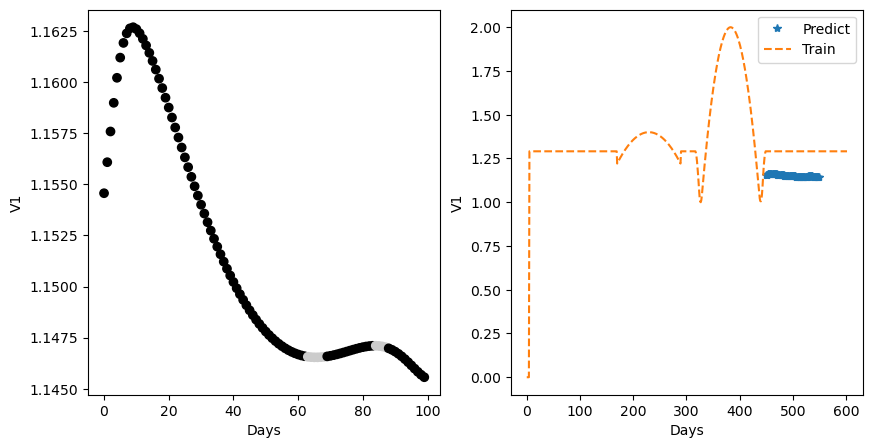

<Figure size 640x480 with 0 Axes>

In [82]:
# run backtest
y_test = [] 
for i in range(1,test_run+1):
    temp = sample.reshape(-1)[:-i]
    y_test.append(temp)
y_test = np.nan_to_num(pad_sequences(y_test,dtype= float,value=np.nan,maxlen=X_val.shape[1]))     
y_test = np.array([model.predict(np.expand_dims(sample_input, axis=0),verbose=False) for sample_input in y_test]).reshape(-1)


# Generate labels 
smooth_dur = test_run//5
res = plateau_clustering(range(len(y_test)),y_test,window_size=2,n_clus=smooth_dur)
has_cut = None
if len(res)>2:
    if res.iloc[-smooth_dur:].plateau.mean()==1 : 
        has_cut = True
    else:
        has_cut=False
else:
    has_cut = False
    
if has_cut : 
    Days = np.argwhere(np.gradient(res.plateau)==0.5)[-1][0]
    print_info(f"In {Days} days we will have a cutoff")
else: 
    print_info("No cuttoff")

if has_cut:
    labels_pred.append(1)
    durations_pred.append(Days)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(res.x,res.orig_y,c=res.plateau,cmap='nipy_spectral')
if has_cut : 
    plt.axvline(np.argwhere(np.gradient(res.plateau)==0.5).flatten()[-1])
plt.xlabel('Days')
plt.ylabel('V1')

plt.subplot(1,2,2)
plt.plot(range(len(sample),len(sample)+test_run),list(y_test),'*',label='Predict')
plt.plot(X[iter],'--',label='Train')
plt.xlabel('Days')
plt.ylabel('V1')
plt.legend()
plt.show()   

plt.tight_layout()
plt.show()

**Labeled as no cutoff**

(603,) (450,) 100


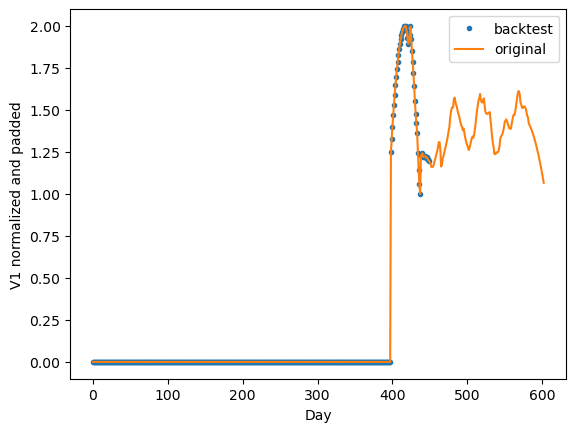

In [83]:
# select a sample 
iter = training_serial_num.index('11507W0217')
sample_orig = X[iter]
sample = sample_orig[:450]
test_run =  100
print(sample_orig.shape,sample.shape,test_run)

plt.plot(sample,'.',label='backtest')
plt.plot(sample_orig,label='original')
plt.xlabel('Day')
plt.ylabel('V1 normalized and padded')
plt.legend()
plt.show()


[INFO]: In 52 days we will have a cutoff 



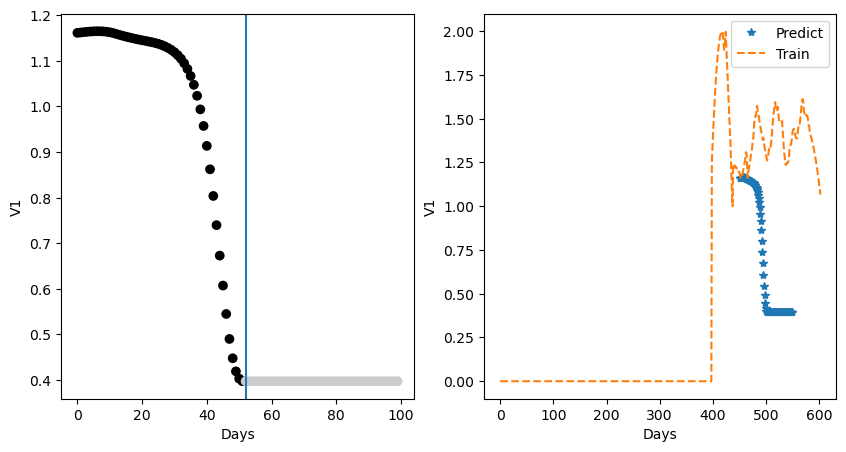

<Figure size 640x480 with 0 Axes>

In [84]:
# run backtest
y_test = [] 
for i in range(1,test_run+1):
    temp = sample.reshape(-1)[:-i]
    y_test.append(temp)
y_test = np.nan_to_num(pad_sequences(y_test,dtype= float,value=np.nan,maxlen=X_val.shape[1]))     
y_test = np.array([model.predict(np.expand_dims(sample_input, axis=0),verbose=False) for sample_input in y_test]).reshape(-1)


# Generate labels 
smooth_dur = test_run//5
res = plateau_clustering(range(len(y_test)),y_test,window_size=2,n_clus=smooth_dur)
has_cut = None
if len(res)>2:
    if res.iloc[-smooth_dur:].plateau.mean()==1 : 
        has_cut = True
    else:
        has_cut=False
else:
    has_cut = False
    
if has_cut : 
    Days = np.argwhere(np.gradient(res.plateau)==0.5)[-1][0]
    print_info(f"In {Days} days we will have a cutoff")
else: 
    print_info("No cuttoff")


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(res.x,res.orig_y,c=res.plateau,cmap='nipy_spectral')
if has_cut : 
    plt.axvline(np.argwhere(np.gradient(res.plateau)==0.5).flatten()[-1])
plt.xlabel('Days')
plt.ylabel('V1')

plt.subplot(1,2,2)
plt.plot(range(len(sample),len(sample)+test_run),list(y_test),'*',label='Predict')
plt.plot(X[iter],'--',label='Train')
plt.xlabel('Days')
plt.ylabel('V1')
plt.legend()
plt.show()   

plt.tight_layout()
plt.show()

After several backtesting experiments, you will see that every time the LSTM is producing numbers which are quite small and constrained and slightly from the actual values showing that the the forecasting is not quite accurate. Post analysis harder regarding the plateau clustering. But if the regression prediction improves we defintely be able to correctly estimate the duration to cutoff.

### Question 12 and 13:

12 - > Can you select some serial_numbers and create time series models to forecast v2? 

13 - > Assess the performance of the models in 12).

The entire process should be repreated for v2. The issue is the model selected requires more data and finetuning to improve it and it's not worth redoing. Inspecting the v2 data will show it has quite the similar nature but with larger number. We will apply the same processing and retrain the model or even try other models and see what results we will get. 

We can asses with the training and testing validation data or by doing backtesting just like before and comparing the lables of the cutoffs and the estimated durations.

**Create plateaus**

In [85]:
smoothed2 = {}
gradient2 = {} 
smooth_dur_dict2= {}
serial_number_s = sorted(summary.query("ts_type!='Constrant' and counter>2").serial_number.tolist())

for serial_number in tqdm(serial_number_s,total=len(serial_number_s)):
    
    ts = quality_v2[serial_number]['ts_resampled']
    smooth_dur = round(ts.shape[0]/5)
    smooth_dur_dict2[serial_number] = smooth_dur
    
    if ts.shape[0] >= 2: 

        # Smooth the data 
        value_s = SF(ts.tolist(),window_length=smooth_dur,polyorder=2)
        smoothed2[serial_number] = pd.Series(value_s,index=ts.index)
        
        # store gradient values 
        grad = pd.Series(np.gradient(smoothed2[serial_number]),index=smoothed2[serial_number].index)
        
        # clustering
        if ts.nunique()==1:
            pass
            
        else:  
            cluster_size = round(ts.shape[0]/10)
            if cluster_size > 35 : cluster_size = 30 
        
            # Implement clustering 
            plateau =  plateau_clustering(ts.index,value_s,window_size=2,n_clus=cluster_size)
        
            # Label horizontal cuttoff
            plateau['cutoff'] = 0
            if plateau.iloc[-smooth_dur:].plateau.mean()==1 : 
                plateau.loc[plateau.iloc[-smooth_dur:].index,'cutoff'] = 1 
        
            # save results
            gradient2[serial_number] = plateau

100%|███████████████████████████████████████| 1363/1363 [01:27<00:00, 15.62it/s]


In [86]:
# Estimate the common date the maximum size of the input layer
training_serial_num = sorted(gradient2.keys())

# Normalize per timeseries
database2 = [] 
for serial_number in training_serial_num:
    ts = gradient2[serial_number].orig_y
    ts = 1+((ts - ts.min())/(ts.max()-ts.min()))
    database2.append(ts.tolist())

X2 = np.nan_to_num(pad_sequences(database2,dtype= float,value=np.nan))

# Reshape
X2_reshaped = X2.reshape(-1, X.shape[1], 1)

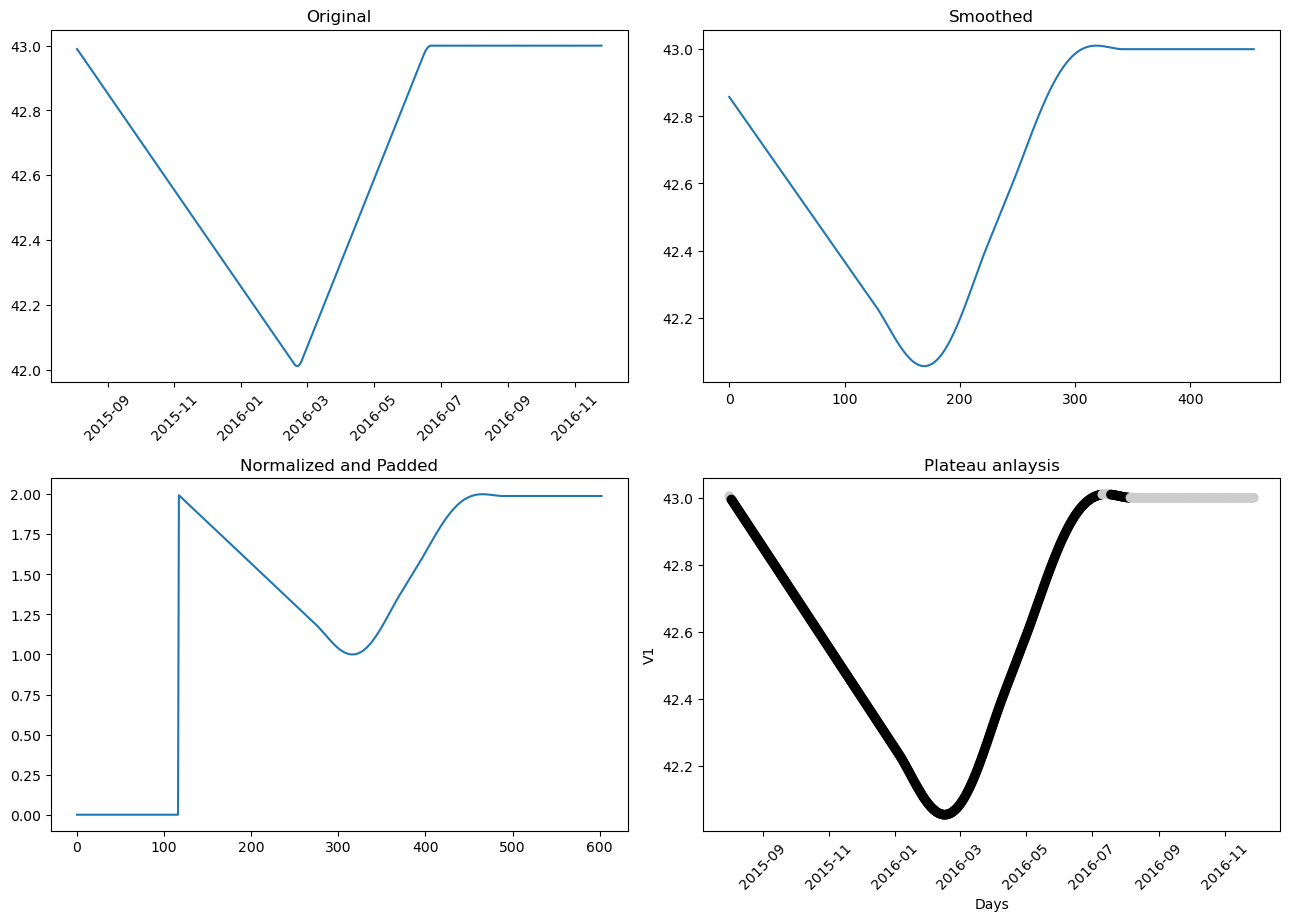

In [87]:
serial_number = '11435C0157'
iter = training_serial_num.index(serial_number)

plt.figure(figsize=(13,13))

plt.subplot(3,2,1)
orig=(quality_v2[serial_number]['trend_component'] + quality_v2[serial_number]['seasonal_component'])
plt.plot(orig)
plt.xticks(rotation=45)
plt.title("Original")


plt.subplot(3,2,2)
plt.plot(gradient2[serial_number].orig_y.to_numpy()[30:])
plt.title('Smoothed')


plt.subplot(3,2,3)
plt.plot(X2[iter])
plt.title("Normalized and Padded")



res = gradient2[serial_number]
plt.subplot(3,2,4)
plt.scatter(res.x,res.orig_y,c=res.plateau,cmap='nipy_spectral')
plt.xlabel('Days')
plt.ylabel('V1')
plt.xticks(rotation=45)
plt.title("Plateau anlaysis")

plt.tight_layout()
plt.show()




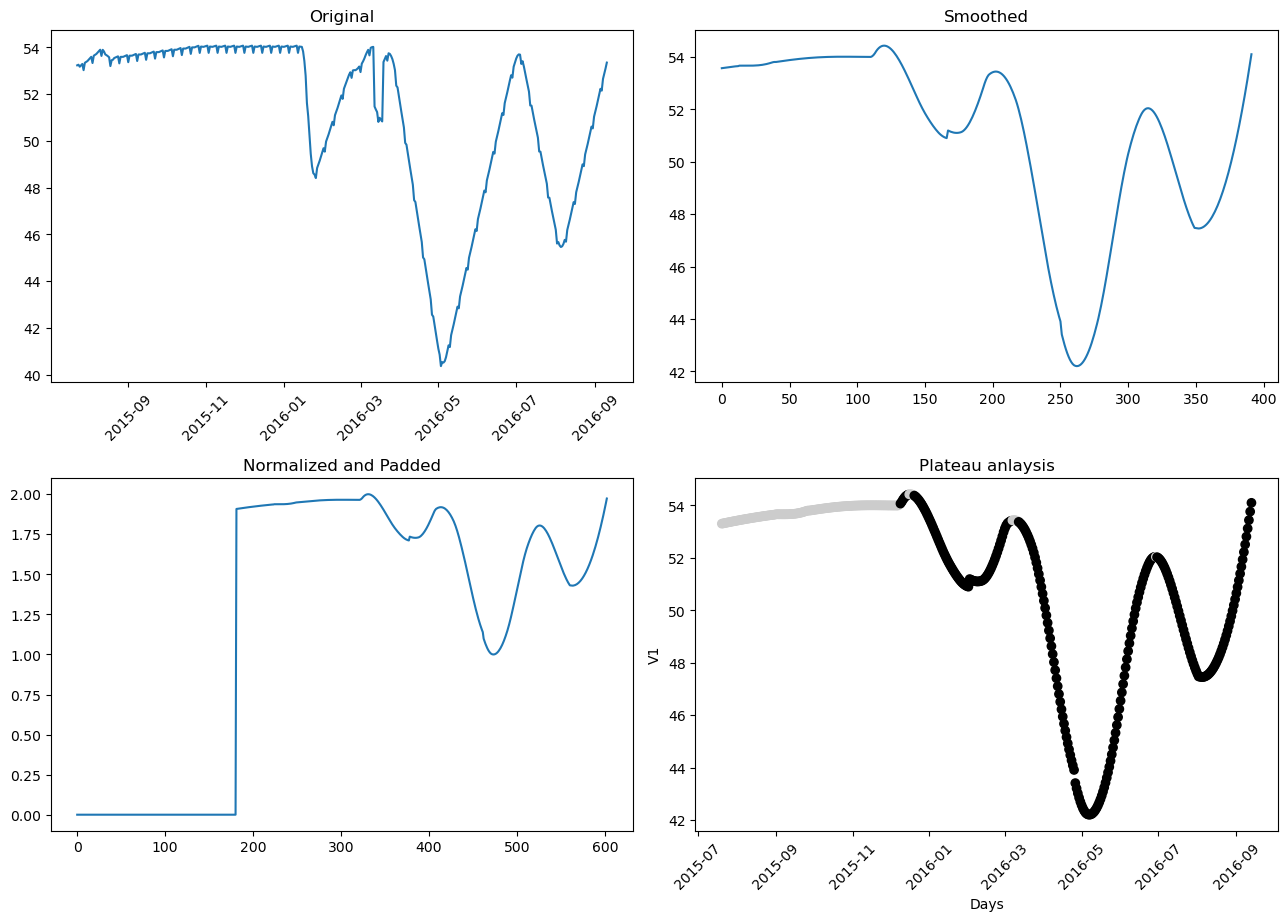

In [88]:
serial_number = '11410W0172'
iter = training_serial_num.index(serial_number)

plt.figure(figsize=(13,13))

plt.subplot(3,2,1)
orig=(quality_v2[serial_number]['trend_component'] + quality_v2[serial_number]['seasonal_component'])
plt.plot(orig)
plt.xticks(rotation=45)
plt.title("Original")


plt.subplot(3,2,2)
plt.plot(gradient2[serial_number].orig_y.to_numpy()[30:])
plt.title('Smoothed')


plt.subplot(3,2,3)
plt.plot(X2[iter])
plt.title("Normalized and Padded")



res = gradient2[serial_number]
plt.subplot(3,2,4)
plt.scatter(res.x,res.orig_y,c=res.plateau,cmap='nipy_spectral')
plt.xlabel('Days')
plt.ylabel('V1')
plt.xticks(rotation=45)
plt.title("Plateau anlaysis")

plt.tight_layout()
plt.show()




## 5. Conclusion

**Summary**

In this project for GE health staff data scientist position assessment, we saw all the steps needed to clean, analyze, preprocess, model, and evaluate
a machine learning model for forecasting time series and estimation of cutoff duration. The data was composed of a set disjoint time series. We had to answer a set of guiding questions along the way. 


**Key Findings and Insights:**

1. We have analyzed groups of disjoint time series which had a variety of date formats, intervals, and era coverages. They were homogenized using resampling, smoothing, and forward padding techniques.
2. There were around 3 qualitative time series categories/classes that we discovered using the decomposition method: Constant, Seasonal, and Trending. Also some of them had quite the linear nature.
3. We developed a clustering tool that was able to detect plateaus and identify the end location of the cutoff plateau and the time needed to arrive at it, which proved to be an efficient tool if the regressive forecasting step of the time series performs well.   

**Model Performance Evaluation:**

The predictive model that we adopted was the LSTM (Long-short-term-memory) neural network architecture. LSTM ingests sequential data even with variable sizes which made it reasonable to use in this project given the nature of the data we had. Our architecture was simple and for the training and validation sets we had a square root of MSE was 0.7 which is about 10% of the mean of V1, placing it in the same ballpark as the magnitudes of the values, thus being acceptable as a first trial prior to tuning and advanced modelling in term of quality. During our analysis, a few visual inspections showed that the regressive predictions were not as accurate as one would expect. They could not capture the real trends. The values did not follow the trends for the training sets and some appeared flat. LSTMs have their pros and cons in terms of especially with gradient vanishing issues.  


**Challenges and Limitations:**

The algorithm that we used needed to be more complex in terms of layers and memory issues. To solve these issues, in is well known both in academic research and industry that algorithms like transformers, reformers, or mamba(SSM) might perform better. Also not having alot of computation power prevented me from training for too long and achieving better results and to investigate gradient issues. Not to forget that we did not have any ground truth. The data revealed that there were plateaus even in the middle of certain time series as a result this will create a degeneracy where we will be confused as which one is the true "end of time series horizontal" cutoff. Domain/industry knowledge is required to explain what is this data and what are the meaning of these cutoffs.

**Future Directions and Opportunities:**

With this preliminary analysis there is yet a lot that can be done, the current evaluation metrics are not enough to evaluate the performance of the system. The future plans for such a project will be: 

1. Defining the ground truth values
2. Using backtesting for more than a single duration and doing back tested cross validations, time based cross validation proves the reality of evolution and whether it generalizes for different eras. 
3. The cutoff analysis might require improvement as in some cases the plateaus were slowly decreasing/increasing and they were still classified as plateaus as they were the slowest changing values. We need a better approach where both class labels and values would be derived. For example in computer vision, YOLO is a convolutional neural network architecture which is used for object detection where both the class and the location of the object in the images are calculated simultaneously, we can use such analogous algorithms for predicting where a time series segment in a cutoff is and it duration by tokenizing the time series segments.
4. And speaking of tokenization, there have been recent publications and releases regarding better algorithms which can handle time series data such as TimesFM from Google and other time series based foundational models which can be used and fine tuned / transferred to our applications. 

**Acknowledgements**

I want to thank the GE health data science team for putting this very interesting assignment, I did really enjoy working on it :) ... pheww

       



